TO DO :

* Baseline everything cf BASELINE_WINDOWS_SUMMARY (need clarification with Ede)
--> Why tho ? see changes before after MM ? Visualisation sure
* Select what to keep --> batch things up
* Talk about the lag /cross correlation with Ede


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.metrics import auc
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from matplotlib.ticker import MultipleLocator
from scipy.stats import wilcoxon
from scipy import stats
from scipy.stats import zscore
from pathlib import Path
import os
import glob

In [3]:
# Path leading to _processedData folders
# data_alingned_path = '/mnt/disk2/Arthur_data/B6J3217-2025-07-02T13-13-14_processedData/aligned_data/B6J3217_downsampled_data_Apply halt: 2s_aligned.csv'
# Define the root path
processed_data_path = 'C:/Users/Arthur/Documents/Master_BIP_CMB/Stage/Data/Cohort1_day3'

# Find all folders ending with '_processedData'
processed_folders = glob.glob(os.path.join(processed_data_path, '*_processedData'))

# For each processed folder, look for 'aligned_data' subfolder
data_aligned_dict = {}
i = 0
for folder in processed_folders:
    aligned_data_path = os.path.join(folder, 'aligned_data')

    # Check if 'aligned_data' exists and find matching files
    if os.path.exists(aligned_data_path):
        matching_files = glob.glob(os.path.join(aligned_data_path, '*_downsampled_data_Apply halt_2s_aligned.csv'))

        # Print or process the matching files
        for file in matching_files:
            print(f"Found file: {file}")
            # Read the CSV file into a DataFrame
            df = pd.read_csv(file)
            # Store the DataFrame in the dictionary with a dynamic key
            data_aligned_dict[f"data_aligned_csv_{i}"] = df
            i += 1

    else:
        print(f"Folder not found: {aligned_data_path}")

# baseline everything cf BASELINE_WINDOWS_SUMMARY
for key in data_aligned_dict.keys():

    # Creation of new column with index of each MM
    halt_index = 0
    halt_indices = []
    prev_halt_time = None

    for _, row in data_aligned_dict[key].iterrows():
        if row['Halt Time'] != prev_halt_time:
            halt_index += 1
            prev_halt_time = row['Halt Time']
        halt_indices.append(halt_index-1)

    data_aligned_dict[key]['halt_index'] = halt_indices

    bin_indices = []

    for _, row in data_aligned_dict[key].iterrows():
        th_time = 10
        for i in range(8):
            if row['Time (s)'] <= th_time:
                bin_index = 7-i
                th_time -=2
        
        bin_indices.append(bin_index)

    data_aligned_dict[key]['bin_index'] = bin_indices

    # Printing every column names to see every variables
    col_names = data_aligned_dict[key].columns
    # print("\n".join(col_names))

for key in data_aligned_dict.keys():
    print(f"Columns in {key}: {data_aligned_dict[key].columns}")


Found file: C:/Users/Arthur/Documents/Master_BIP_CMB/Stage/Data/Cohort1_day3\B6J2718-2024-12-10T12-57-02_processedData\aligned_data\B6J2718_downsampled_data_Apply halt_2s_aligned.csv
Found file: C:/Users/Arthur/Documents/Master_BIP_CMB/Stage/Data/Cohort1_day3\B6J2719-2024-12-10T13-36-31_processedData\aligned_data\B6J2719_downsampled_data_Apply halt_2s_aligned.csv
Found file: C:/Users/Arthur/Documents/Master_BIP_CMB/Stage/Data/Cohort1_day3\B6J2721-2024-12-10T14-18-54_processedData\aligned_data\B6J2721_downsampled_data_Apply halt_2s_aligned.csv
Found file: C:/Users/Arthur/Documents/Master_BIP_CMB/Stage/Data/Cohort1_day3\B6J2722-2024-12-10T14-58-52_processedData\aligned_data\B6J2722_downsampled_data_Apply halt_2s_aligned.csv
Found file: C:/Users/Arthur/Documents/Master_BIP_CMB/Stage/Data/Cohort1_day3\B6J2723-2024-12-10T15-36-13_processedData\aligned_data\B6J2723_downsampled_data_Apply halt_2s_aligned.csv
Columns in data_aligned_csv_0: Index(['Encoder', 'Position_0X', 'Position_0Y', 'Cumul

## Getting data for all MM across the session

## Getting the % change in running and turning speed from 2s before to 2s after MM

In [4]:
dict_ratios = {key: [] for key in data_aligned_dict.keys()}

for key in data_aligned_dict.keys():
    print('\n')
    print(f"Processing {key}...")

    dict_changes_turning_speed = {MM: [] for MM in data_aligned_dict[key]['halt_index']}
    dict_changes_running_speed = {MM: [] for MM in data_aligned_dict[key]['halt_index']}
    dict_changes_activ = {MM: [] for MM in data_aligned_dict[key]['halt_index']}
    dict_activ_mean_after_mm = {MM: [] for MM in data_aligned_dict[key]['halt_index']}
    dict_changes_ellipse_X = {MM: [] for MM in data_aligned_dict[key]['halt_index']}
    dict_changes_ellipse_Y = {MM: [] for MM in data_aligned_dict[key]['halt_index']}
    dict_changes_pupil_diam = {MM: [] for MM in data_aligned_dict[key]['halt_index']}


    for i in range(np.max(data_aligned_dict[key]['halt_index'])+1):

        spe_halt_data = data_aligned_dict[key].loc[data_aligned_dict[key]['halt_index'] == i]

        spe_halt_bin_before_data = spe_halt_data.loc[spe_halt_data['bin_index'] == 2]
        spe_halt_bin_after_data = spe_halt_data.loc[spe_halt_data['bin_index'] == 3]

        mean_turning_before = np.mean(np.abs(spe_halt_bin_before_data['Velocity_0Y']))
        mean_turning_after = np.mean(np.abs(spe_halt_bin_after_data['Velocity_0Y']))

        mean_running_before = np.mean(np.abs(spe_halt_bin_before_data['Velocity_0X']))
        mean_running_after = np.mean(np.abs(spe_halt_bin_after_data['Velocity_0X']))

        mean_activ_before = np.mean(np.abs(spe_halt_bin_before_data['z_560']))
        mean_activ_after = np.mean(np.abs(spe_halt_bin_after_data['z_560']))

        if 'Ellipse.Center.X_eye1' in spe_halt_bin_before_data.columns and 'Ellipse.Center.X_eye1' in spe_halt_bin_after_data.columns:
            mean_ellipse_X_before = np.mean(np.abs(spe_halt_bin_before_data['Ellipse.Center.X_eye1']))
            mean_ellipse_X_after = np.mean(np.abs(spe_halt_bin_after_data['Ellipse.Center.X_eye1']))
            ratio_ellipse_X__before_after = (mean_ellipse_X_after-mean_ellipse_X_before)/mean_ellipse_X_before
        else:
            print(f"Warning: Missing data for Ellipse.Center.X_eye1 in halt_index {i} of {key}. Skipping ratio calculation for this variable.")
            ratio_ellipse_X__before_after = 0

        if 'Ellipse.Center.Y_eye1' in spe_halt_bin_before_data.columns and 'Ellipse.Center.Y_eye1' in spe_halt_bin_after_data.columns:
            mean_ellipse_Y_before = np.mean(np.abs(spe_halt_bin_before_data['Ellipse.Center.Y_eye1']))
            mean_ellipse_Y_after = np.mean(np.abs(spe_halt_bin_after_data['Ellipse.Center.Y_eye1']))
            ratio_ellipse_Y_before_after = (mean_ellipse_Y_after-mean_ellipse_Y_before)/mean_ellipse_Y_before
        else:
            print(f"Warning: Missing data for Ellipse.Center.Y_eye1 in halt_index {i} of {key}. Skipping ratio calculation for this variable.")
            ratio_ellipse_Y_before_after = 0

        if 'Pupil.Diameter_eye1' in spe_halt_bin_before_data.columns and 'Pupil.Diameter_eye1' in spe_halt_bin_after_data.columns:
            mean_pupil_diam_before = np.mean(np.abs(spe_halt_bin_before_data['Pupil.Diameter_eye1']))
            mean_pupil_diam_after = np.mean(np.abs(spe_halt_bin_after_data['Pupil.Diameter_eye1']))
            ratio_pupil_diam_before_after = (mean_pupil_diam_after-mean_pupil_diam_before)/mean_pupil_diam_before
        else:
            print(f"Warning: Missing data for Pupil.Diameter_eye1 in halt_index {i} of {key}. Skipping ratio calculation for this variable.")
            ratio_pupil_diam_before_after = 0


        ratio_turning_before_after = (mean_turning_after-mean_turning_before)/mean_turning_before

        ratio_running_before_after = (mean_running_after-mean_running_before)/mean_running_before

        ratio_activ_before_after = (mean_activ_after-mean_activ_before)/mean_activ_before


        dict_changes_turning_speed[i] = np.round(ratio_turning_before_after,2)

        dict_changes_running_speed[i] = np.round(ratio_running_before_after, 2)

        dict_changes_activ[i] = np.round(ratio_activ_before_after, 2)

        dict_activ_mean_after_mm[i] = np.mean(np.abs(spe_halt_bin_after_data['z_560']))

        dict_changes_ellipse_X[i] = np.round(ratio_ellipse_X__before_after,2)

        dict_changes_ellipse_Y[i] = np.round(ratio_ellipse_Y_before_after,2)

        dict_changes_pupil_diam[i] = np.round(ratio_pupil_diam_before_after,2)

    table_global_ratio = pd.DataFrame({
        'z_560': list(dict_changes_activ.values()),
        'Velocity_0X': list(dict_changes_running_speed.values()),
        'Velocity_0Y': list(dict_changes_turning_speed.values()),
        'Ellipse.Center.X_eye1': list(dict_changes_ellipse_X.values()),
        'Ellipse.Center.Y_eye1': list(dict_changes_ellipse_Y.values()),
        'Pupil.Diameter_eye1': list(dict_changes_pupil_diam.values()),
    })

    dict_ratios[key] = table_global_ratio

dict_ratios



Processing data_aligned_csv_0...


Processing data_aligned_csv_1...


Processing data_aligned_csv_2...


Processing data_aligned_csv_3...


Processing data_aligned_csv_4...


{'data_aligned_csv_0':     z_560  Velocity_0X  Velocity_0Y  Ellipse.Center.X_eye1  \
 0    2.78        -0.14        -0.31                  -0.01   
 1    1.47         1.30        -0.56                   0.02   
 2    1.20         1.80         3.36                   0.22   
 3    9.14         0.08        -0.32                  -0.19   
 4    0.31         1.83         1.09                   0.09   
 5    0.56        -0.23        -0.21                  -0.13   
 6    0.77        -0.09        -0.31                  -0.48   
 7    3.69        36.87         1.88                  -0.39   
 8    0.83         0.59        -0.23                  -0.55   
 9    0.66         0.29        -0.13                  -0.83   
 10   5.99         2.25         1.01                  -0.28   
 11   1.27        20.05         2.82                  -0.10   
 12   3.39         8.92         4.76                   0.74   
 13   0.78         3.00         1.06                   0.84   
 14   0.71         0.30        -0

In [5]:
dict_ratios['data_aligned_csv_0']['z_560'][0]

2.78

[-0.31, -0.56, 3.36, -0.32, 1.09, -0.21, -0.31, 1.88, -0.23, -0.13, 1.01, 2.82, 4.76, 1.06, -0.2, -0.56, -0.6, -0.24, -0.41, -0.23, 0.04, -0.26, 0.36, 0.44, -0.04, 0.44, 0.74, 1.16, 3.67, -0.22, -0.2, 0.17, -0.49, 0.03, -0.65, 0.18, 1.18, 0.02, 0.4, -0.42, 0.29, -0.42, 0.94, -0.52, 0.32, 0.27, 0.88, -0.57, 1.09, 0.11, 0.07, -0.27, 0.07, -0.19, 4.15, 2.24, 0.53, 0.3, -0.42, -0.26, -0.46, -0.05, 0.16, 0.01, -0.44, -0.62, 0.25, 0.03, 0.41, -0.42, -0.91, -0.82, -0.53, 3.51, -0.31, 3.81, 1.7, -0.29, 0.29, -0.19, -0.33, 0.27, -0.31, 1.32, 0.05, 1.46, -0.51, 2.45, 0.46, 3.69, -0.29, -0.34, -0.32, 0.37, -0.06, 0.42, 0.59, 0.37, -0.18, -0.32, -0.16, 0.1, -0.86, -0.27, -0.35, 0.29, 0.13, 0.0, 0.72, 0.09, 0.13, -0.55, 0.82, -0.68, 0.62, -0.3, -0.12, -0.13, 0.32, -0.12, -0.5, -0.47, -0.43, -0.78, -0.55, -0.6, 2.21, -0.51]
-0.613 3.1709999999999954


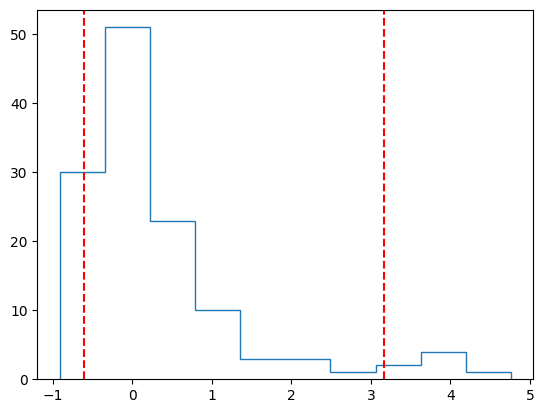

In [6]:
ratio_turning, ratio_running, ratio_activ, activ_mean = [], [], [], []
for key in data_aligned_dict.keys():
    for i in range(len(dict_ratios[key])):
        diff_t = dict_ratios[key]['Velocity_0Y'][i]
        diff_r = dict_ratios[key]['Velocity_0X'][i]
        diff_a = dict_ratios[key]['z_560'][i]
        # mean_a = dict_activ_mean_after_mm[i]
        ratio_turning.append(diff_t)
        ratio_running.append(diff_r)
        ratio_activ.append(diff_a)
        # activ_mean.append(mean_a)

print(ratio_turning)
counts, bins = np.histogram(ratio_turning)
res5 = np.percentile(ratio_turning,5)
res95 = np.percentile(ratio_turning,95)
print(res5, res95)
plt.stairs(counts, bins)
plt.axvline(res5, color='r', linestyle='--')
plt.axvline(res95, color='r', linestyle='--')

[-0.31, -0.56, 3.36, -0.32, 1.09, -0.21, -0.31, 1.88, -0.23, -0.13, 1.01, 2.82, 4.76, 1.06, -0.2, -0.56, -0.6, -0.24, -0.41, -0.23, 0.04, -0.26, 0.36, 0.44, -0.04, 0.44, 0.74, 1.16, 3.67, -0.22, -0.2, 0.17, -0.49, 0.03, -0.65, 0.18, 1.18, 0.02, 0.4, -0.42, 0.29, -0.42, 0.94, -0.52, 0.32, 0.27, 0.88, -0.57, 1.09, 0.11, 0.07, -0.27, 0.07, -0.19, 4.15, 2.24, 0.53, 0.3, -0.42, -0.26, -0.46, -0.05, 0.16, 0.01, -0.44, -0.62, 0.25, 0.03, 0.41, -0.42, -0.91, -0.82, -0.53, 3.51, -0.31, 3.81, 1.7, -0.29, 0.29, -0.19, -0.33, 0.27, -0.31, 1.32, 0.05, 1.46, -0.51, 2.45, 0.46, 3.69, -0.29, -0.34, -0.32, 0.37, -0.06, 0.42, 0.59, 0.37, -0.18, -0.32, -0.16, 0.1, -0.86, -0.27, -0.35, 0.29, 0.13, 0.0, 0.72, 0.09, 0.13, -0.55, 0.82, -0.68, 0.62, -0.3, -0.12, -0.13, 0.32, -0.12, -0.5, -0.47, -0.43, -0.78, -0.55, -0.6, 2.21, -0.51]


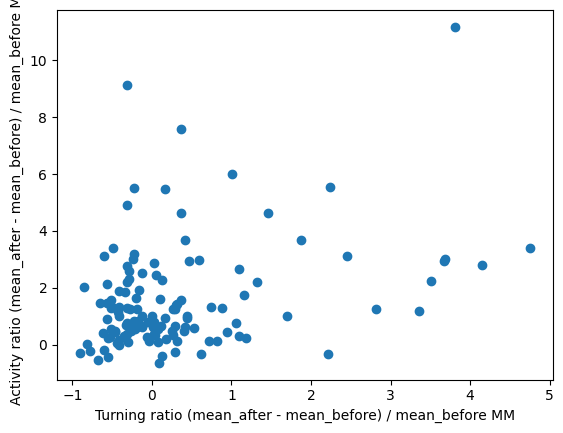

In [7]:
print(ratio_turning)
plt.scatter(ratio_turning, ratio_activ)
plt.xlabel("Turning ratio (mean_after - mean_before) / mean_before MM")
plt.ylabel("Activity ratio (mean_after - mean_before) / mean_before MM")
plt.show()

In [8]:
data_aligned_dict

{'data_aligned_csv_0':          Encoder  Position_0X  Position_0Y  CumulativeCounts_0X  \
 0       257.7982       5.3904   -6741.2109             679112.0   
 1       257.7991       5.3904   -6741.2292             679112.0   
 2       257.8000       5.3904   -6741.2477             679114.0   
 3       257.8011       5.3904   -6741.2660             679114.0   
 4       257.8023       5.3904   -6741.2839             679114.0   
 ...          ...          ...          ...                  ...   
 576031  147.2431      78.7268  -31523.2370            9918324.0   
 576032  147.2431      78.7268  -31523.2375            9918324.0   
 576033  147.2431      78.7267  -31523.2379            9918323.0   
 576034  147.2431      78.7267  -31523.2384            9918323.0   
 576035  147.2431      78.7267  -31523.2388            9918323.0   
 
         CumulativeCounts_0Y  dfF_470  dfF_560  dfF_410   z_470   z_560  ...  \
 0                -1482310.0   0.0024   0.9730   0.9957  0.1721 -1.4471  ...   


In [9]:
clef = list(data_aligned_dict.keys())
print(clef[0])
spe_halt_data = data_aligned_dict[clef[0]].loc[data_aligned_dict[clef[0]]['halt_index'] == 0]
spe_halt_data

data_aligned_csv_0


,Encoder,Position_0X,Position_0Y,CumulativeCounts_0X,CumulativeCounts_0Y,dfF_470,dfF_560,dfF_410,z_470,z_560,...,Ellipse.Center.X_eye1,Ellipse.Center.Y_eye1,Pupil.Diameter_eye1,saccade_event_eye1,saccade_event_eye2,Time (s),Halt Time,saccade_probability_eye1,halt_index,bin_index
0,257.7982,5.3904,-6741.2109,679112.0,-1482310.0,0.0024,0.9730,0.9957,0.1721,-1.4471,...,5.4835,-2.1144,15.8619,False,False,-6.000,1904-01-06 02:44:06.958356,0.000,0,0
1,257.7991,5.3904,-6741.2292,679112.0,-1482310.0,0.0024,0.9730,0.9957,0.1728,-1.4472,...,5.4844,-2.1140,15.8606,False,False,-5.999,1904-01-06 02:44:06.958356,0.000,0,0
2,257.8000,5.3904,-6741.2477,679114.0,-1482349.0,0.0024,0.9730,0.9957,0.1732,-1.4471,...,5.4853,-2.1136,15.8594,False,False,-5.998,1904-01-06 02:44:06.958356,0.000,0,0
3,257.8011,5.3904,-6741.2660,679114.0,-1482349.0,0.0024,0.9730,0.9957,0.1734,-1.4466,...,5.4862,-2.1133,15.8581,False,False,-5.997,1904-01-06 02:44:06.958356,0.000,0,0
4,257.8023,5.3904,-6741.2839,679114.0,-1482349.0,0.0024,0.9730,0.9957,0.1734,-1.4459,...,5.4871,-2.1129,15.8568,False,False,-5.996,1904-01-06 02:44:06.958356,0.000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15996,282.6828,5.9101,-7059.8803,744559.0,-1552675.0,-0.0090,1.0293,0.9921,-1.3094,1.8751,...,15.6591,-1.7276,19.1157,False,False,9.996,1904-01-06 02:44:06.958356,0.002,0,7
15997,282.6966,5.9101,-7060.0264,744559.0,-1552675.0,-0.0089,1.0292,0.9922,-1.2998,1.8709,...,15.6613,-1.7294,19.1024,False,False,9.997,1904-01-06 02:44:06.958356,0.002,0,7
15998,282.7105,5.9101,-7060.1701,744559.0,-1552675.0,-0.0088,1.0291,0.9922,-1.2897,1.8675,...,15.6635,-1.7313,19.0892,False,False,9.998,1904-01-06 02:44:06.958356,0.002,0,7
15999,282.7244,5.9101,-7060.3131,744559.0,-1552675.0,-0.0087,1.0291,0.9922,-1.2792,1.8652,...,15.6657,-1.7331,19.0760,False,False,9.999,1904-01-06 02:44:06.958356,0.002,0,7


## I'm trying something ; _ ;

In [10]:
def get_time_lag(key = 0, MM_num = 0, first_signal = 'z_560', second_signal = 'Velocity_0Y', absolute = False, plot = False):

    clef = list(data_aligned_dict.keys())
    spe_halt_data = data_aligned_dict[clef[key]].loc[data_aligned_dict[clef[key]]['halt_index'] == MM_num]

    # Time wimdow of 4.5s
    spe_halt_selc_data = spe_halt_data.loc[spe_halt_data['Time (s)'] >= -2]
    spe_halt_selc_data = spe_halt_selc_data.loc[spe_halt_data['Time (s)'] <= 2.5]
    spe_halt_bin_data2 = spe_halt_selc_data

    # Getting activity and behavioral data z_score so the scale does not mess with everything
    if absolute:
        spe_halt_bin_data2[second_signal] = (np.abs((spe_halt_bin_data2[second_signal].values))/100)
    else:
        spe_halt_bin_data2[second_signal] = ((spe_halt_bin_data2[second_signal].values)/100)

    spe_halt_bin_data2[first_signal] = ((spe_halt_bin_data2[first_signal].values))
    time = spe_halt_bin_data2['Time (s)'].values
    act = spe_halt_bin_data2[first_signal].values
        
    # Getting the peak of activity before 1.5s after MM and it's related time and index
    # Consider that a peak occuring after 1.5s post MM is no longer related to it (arbitrary)
    spe_halt_bin_data3 = spe_halt_selc_data.loc[spe_halt_selc_data['Time (s)'] >= 0]
    spe_halt_bin_data3 = spe_halt_bin_data3.loc[spe_halt_bin_data3['Time (s)'] <= 1.5]
    # +2000 index because plotting start at -2s, so to account for it in the search of the max value after MM
    peak_idx = np.argmax((spe_halt_bin_data3[first_signal])) + 2000
    peak_time = time[peak_idx]
    # print(peak_time)
    peak_value_a = act[peak_idx]
    # print(peak_value_a)

    # Setting time window for looking at max speed between the time of max activity +0.2s and 2s 
    # Consider that what comes after is no longer due to the MM
    spe_halt_bin_data_corrected = spe_halt_bin_data2.loc[spe_halt_bin_data2['Time (s)'] >= peak_time+0.2]
    spe_halt_bin_data_corrected = spe_halt_bin_data_corrected.loc[spe_halt_bin_data_corrected['Time (s)'] <= 2]
    # print(spe_halt_bin_data_corrected)

    peak_value_b = max(spe_halt_bin_data_corrected[second_signal].values, key=abs)
    # print(peak_value_b)
    time_peak_b = spe_halt_bin_data_corrected.loc[spe_halt_bin_data_corrected[second_signal] == peak_value_b].iloc[0]
    # print(time_peak_b['Time (s)'])

    time_lag = time_peak_b['Time (s)'] - peak_time

    spe_halt_before_data = spe_halt_data.loc[spe_halt_data['Time (s)'] >= -1.5]
    spe_halt_before_data = spe_halt_before_data.loc[spe_halt_before_data['Time (s)'] <= 0]

    spe_halt_before_data[second_signal] = (spe_halt_before_data[second_signal].values)/100

    peak_value_before = max(spe_halt_before_data[second_signal].values, key=abs)
    # print(peak_value_before, peak_value_after)
    if peak_value_before*peak_value_b < 0:
        print('🔃 Direction changed after MM')
    else:
        print('Direction did not changed after MM')

    print(f'time lag : {time_lag:.2f}s')

    if plot :

        fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))

        # Plot signals
        ax1.plot(time, spe_halt_bin_data2[second_signal].values, label=f'{second_signal}/100', color='blue')
        ax1.plot(time, spe_halt_bin_data2[first_signal].values, label=first_signal, color='orange')

        ylimits = ax1.get_ylim()
        rect_h = ylimits[1] - ylimits[0]
        patch = patches.Rectangle((peak_time, ylimits[0]), time_lag, rect_h, color='green', alpha=0.1)
        ax1.add_patch(patch)
        ax1.text(peak_time+(time_lag/2), ylimits[1], f'{time_lag:.2f}s', fontsize=10, ha='center', va='bottom')

        ax1.set_title(f'Mouse #{key}, MM #{MM_num}')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Amplitude')
        ax1.scatter(time_peak_b['Time (s)'], peak_value_b, color='red')
        ax1.scatter(peak_time, peak_value_a, color='red')
        ax1.axvline(x=0, color='gray', linestyle='--')
        ax1.axhline(y=0, color='gray', linestyle='--')
        ax1.legend()
        ax1.grid()
        plt.show()

In [11]:
def get_time_lag_v2(key = 0, MM_num = 0, first_signal = 'z_560', second_signal = 'Velocity_0Y', absolute = False, margin = 0.4, plot = False):

    clef = list(data_aligned_dict.keys())
    spe_halt_data = data_aligned_dict[clef[key]].loc[data_aligned_dict[clef[key]]['halt_index'] == MM_num]

    # Time wimdow of 4.5s
    spe_halt_selc_data = spe_halt_data.loc[spe_halt_data['Time (s)'] >= -2]
    spe_halt_selc_data = spe_halt_selc_data.loc[spe_halt_data['Time (s)'] <= 2.5]
    spe_halt_bin_data2 = spe_halt_selc_data

    # Getting activity and behavioral data z_score so the scale does not mess with everything
    if absolute:
        spe_halt_bin_data2[second_signal] = (np.abs((spe_halt_bin_data2[second_signal].values))/100)
    else:
        spe_halt_bin_data2[second_signal] = ((spe_halt_bin_data2[second_signal].values)/100)

    spe_halt_bin_data2[first_signal] = ((spe_halt_bin_data2[first_signal].values))
    time = spe_halt_bin_data2['Time (s)'].values
    act = spe_halt_bin_data2[first_signal].values
        
    # Getting the peak of activity before 1.5s after MM and it's related time and index
    # Consider that a peak occuring after 1.5s post MM is no longer related to it (arbitrary)
    spe_halt_bin_data3 = spe_halt_selc_data.loc[spe_halt_selc_data['Time (s)'] >= 0]
    spe_halt_bin_data3 = spe_halt_bin_data3.loc[spe_halt_bin_data3['Time (s)'] <= 1.5]
    # +2000 index because plotting start at -2s, so to account for it in the search of the max value after MM
    peak_idx = np.argmax((spe_halt_bin_data3[first_signal])) + 2000
    peak_time = time[peak_idx]
    # print(peak_time)
    peak_value_a = act[peak_idx]
    # print(peak_value_a)

    # Setting time window for looking at max speed between the time of max activity +0.2s and 2s 
    # Consider that what comes after is no longer due to the MM
    spe_halt_bin_data_corrected = spe_halt_bin_data2.loc[spe_halt_bin_data2['Time (s)'] >= peak_time+0.2]
    spe_halt_bin_data_corrected = spe_halt_bin_data_corrected.loc[spe_halt_bin_data_corrected['Time (s)'] <= 2]
    # print(spe_halt_bin_data_corrected)

    velo = spe_halt_bin_data_corrected['Velocity_0Y'].values
    time2 = spe_halt_bin_data_corrected['Time (s)'].values
    slopes = []

    for i in range(len(velo)-1):
        slope = (velo[i+1] - velo[i])/(time2[i+1] - time2[i])
        slopes.append(slope)

    for i, slope in enumerate(slopes):
        if -margin <= slope <= margin:
            index_closest_zero = i
            time_b = time2[i]
            time_lag = time_b - peak_time
            value_b = velo[index_closest_zero]
            # print(f'First slope in the margin : {slope} at t = {time_b} s')
            break
    else:
        print(f'No slope at 0 ± {margin}, taking maximum value.') 
        value_b = max(spe_halt_bin_data_corrected[second_signal].values, key=abs)
        time_peak_b = spe_halt_bin_data_corrected.loc[spe_halt_bin_data_corrected[second_signal] == value_b].iloc[0]
        time_lag = time_peak_b['Time (s)'] - peak_time
        time_b = time_peak_b['Time (s)']

    spe_halt_before_data = spe_halt_data.loc[spe_halt_data['Time (s)'] >= -1.5]
    spe_halt_before_data = spe_halt_before_data.loc[spe_halt_before_data['Time (s)'] <= 0]

    spe_halt_before_data[second_signal] = (spe_halt_before_data[second_signal].values)/100

    peak_value_before = max(spe_halt_before_data[second_signal].values, key=abs)
    # print(peak_value_before, peak_value_after)
    if peak_value_before*value_b < 0:
        print('🔃 Direction changed after MM')
        change = True
    else:
        print('Direction did not changed after MM')
        change = False

    print(f'time lag : {time_lag:.2f}s')

    if plot :
        fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))

        # Plot signals
        ax1.plot(time, spe_halt_bin_data2[second_signal].values, label=f'{second_signal}/100', color='blue')
        ax1.plot(time, spe_halt_bin_data2[first_signal].values, label=first_signal, color='orange')

        ylimits = ax1.get_ylim()
        rect_h = ylimits[1] - ylimits[0]
        patch = patches.Rectangle((peak_time, ylimits[0]), time_lag, rect_h, color='green', alpha=0.1)
        ax1.add_patch(patch)
        ax1.text(peak_time+(time_lag/2), ylimits[1], f'{time_lag:.2f}s', fontsize=10, ha='center', va='bottom')

        ax1.set_title(f'Mouse #{key}, MM #{MM_num}')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Amplitude')
        ax1.scatter(time_b, value_b, color='red')
        ax1.scatter(peak_time, peak_value_a, color='red')
        ax1.axvline(x=0, color='gray', linestyle='--')
        ax1.axhline(y=0, color='gray', linestyle='--')
        ax1.legend()
        ax1.grid()
        plt.show()
    
    return time_lag, change

Direction did not changed after MM
time lag : 0.20s


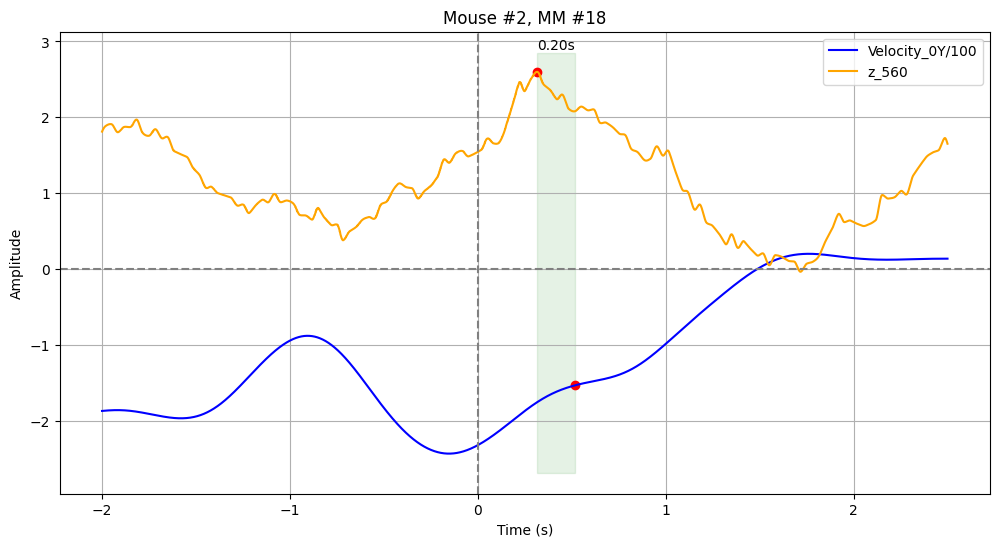



🔃 Direction changed after MM
time lag : 1.37s


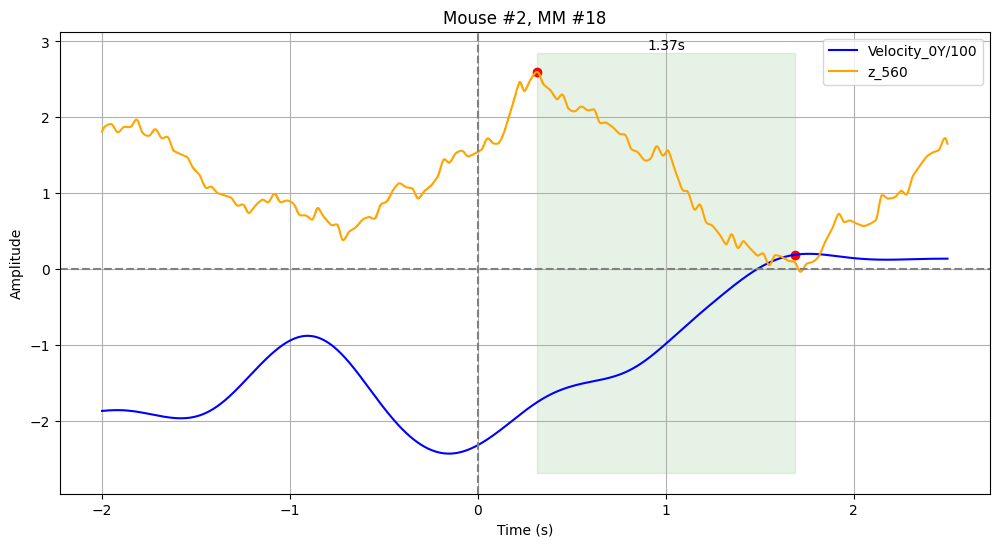

(1.374, True)

In [12]:
# 1 2 3 4 7 8 9 12 16 25
mouse_id = 2
MM_ID = 18
get_time_lag(key = mouse_id, MM_num = MM_ID, first_signal = 'z_560', second_signal = 'Velocity_0Y', absolute = False, plot=True)
print('\n')
get_time_lag_v2(key = mouse_id, MM_num = MM_ID, first_signal = 'z_560', second_signal = 'Velocity_0Y', absolute = False, margin = 0.35, plot=True)

## Getting the time lag between the peak of the first signal and the peak of the second signal, for each MM across the session

In [13]:
dict_lags_change_direction = {key: [] for key in data_aligned_dict.keys()}
lags_list = []
for mouse_id in range(len(data_aligned_dict.keys())):
    print(f'Processing Mouse #{mouse_id}...')
    for MM_ID in range(np.max(data_aligned_dict[clef[mouse_id]]['halt_index'])+1):
        print(f'Processing MM #{MM_ID}...')
        # get_time_lag(key = mouse_id, MM_num = MM_ID, first_signal = 'z_560', second_signal = 'Velocity_0Y', absolute = False, plot=False)
        # print('\n')
        time_lag, change = get_time_lag_v2(key = mouse_id, MM_num = MM_ID, first_signal = 'z_560', second_signal = 'Velocity_0Y', absolute = False, margin = 0.35, plot=False)
        dict_lags_change_direction[clef[mouse_id]].append((time_lag, change))
        lags_list.append(time_lag)
        print('\n')
dict_lags_change_direction
np.mean(lags_list)

Processing Mouse #0...
Processing MM #0...
Direction did not changed after MM
time lag : 0.47s


Processing MM #1...
🔃 Direction changed after MM
time lag : 0.38s


Processing MM #2...
🔃 Direction changed after MM
time lag : 0.76s


Processing MM #3...
Direction did not changed after MM
time lag : 0.68s


Processing MM #4...
Direction did not changed after MM
time lag : 0.56s


Processing MM #5...
🔃 Direction changed after MM
time lag : 1.31s


Processing MM #6...
🔃 Direction changed after MM
time lag : 0.20s


Processing MM #7...
🔃 Direction changed after MM
time lag : 0.37s


Processing MM #8...
Direction did not changed after MM
time lag : 0.75s


Processing MM #9...
No slope at 0 ± 0.35, taking maximum value.
Direction did not changed after MM
time lag : 0.20s


Processing MM #10...
No slope at 0 ± 0.35, taking maximum value.
🔃 Direction changed after MM
time lag : 0.95s


Processing MM #11...
Direction did not changed after MM
time lag : 0.35s


Processing MM #12...
Direction did 

0.5177031249999999

## Getting the running/turning speed and z_560 before and after MM

In [16]:
dict_means_before_after = {key: [] for key in data_aligned_dict.keys()}

for key in data_aligned_dict.keys():
    print('\n')
    print(f"Processing {key}...")

    dict_turning_speed_before = {MM: [] for MM in data_aligned_dict[key]['halt_index']}
    dict_turning_speed_after = {MM: [] for MM in data_aligned_dict[key]['halt_index']}
    dict_running_speed_before = {MM: [] for MM in data_aligned_dict[key]['halt_index']}
    dict_running_speed_after = {MM: [] for MM in data_aligned_dict[key]['halt_index']}
    dict_activ_before = {MM: [] for MM in data_aligned_dict[key]['halt_index']}
    dict_activ_after = {MM: [] for MM in data_aligned_dict[key]['halt_index']}
    dict_ellipse_X_before = {MM: [] for MM in data_aligned_dict[key]['halt_index']}
    dict_ellipse_X_after = {MM: [] for MM in data_aligned_dict[key]['halt_index']}
    dict_ellipse_Y_before = {MM: [] for MM in data_aligned_dict[key]['halt_index']}
    dict_ellipse_Y_after = {MM: [] for MM in data_aligned_dict[key]['halt_index']}
    dict_pupil_diam_before = {MM: [] for MM in data_aligned_dict[key]['halt_index']}
    dict_pupil_diam_after = {MM: [] for MM in data_aligned_dict[key]['halt_index']}

    for i in range(np.max(data_aligned_dict[key]['halt_index'])+1):
        spe_halt_data = data_aligned_dict[key].loc[data_aligned_dict[key]['halt_index'] == i]

        spe_halt_bin_before_data = spe_halt_data.loc[spe_halt_data['bin_index'] == 2]
        spe_halt_bin_after_data = spe_halt_data.loc[spe_halt_data['bin_index'] == 3]

        mean_turning_before = np.mean(np.abs(spe_halt_bin_before_data['Velocity_0Y']))
        mean_turning_after = np.mean(np.abs(spe_halt_bin_after_data['Velocity_0Y']))

        mean_running_before = np.mean(np.abs(spe_halt_bin_before_data['Velocity_0X']))
        mean_running_after = np.mean(np.abs(spe_halt_bin_after_data['Velocity_0X']))

        mean_activ_before = np.mean(spe_halt_bin_before_data['z_560'])
        mean_activ_after = np.mean(spe_halt_bin_after_data['z_560'])

        if 'Ellipse.Center.X_eye1' in spe_halt_bin_before_data.columns and 'Ellipse.Center.X_eye1' in spe_halt_bin_after_data.columns:
            mean_ellipse_X_before = np.mean(np.abs(spe_halt_bin_before_data['Ellipse.Center.X_eye1']))
            mean_ellipse_X_after = np.mean(np.abs(spe_halt_bin_after_data['Ellipse.Center.X_eye1']))
        else:
            print(f"Warning: Missing data for Ellipse.Center.X_eye1 in halt_index {i} of {key}. Skipping ratio calculation for this variable.")
            mean_ellipse_X_before = 0
            mean_ellipse_X_after = 0

        if 'Ellipse.Center.Y_eye1' in spe_halt_bin_before_data.columns and 'Ellipse.Center.Y_eye1' in spe_halt_bin_after_data.columns:
            mean_ellipse_Y_before = np.mean(np.abs(spe_halt_bin_before_data['Ellipse.Center.Y_eye1']))
            mean_ellipse_Y_after = np.mean(np.abs(spe_halt_bin_after_data['Ellipse.Center.Y_eye1']))
        else:
            print(f"Warning: Missing data for Ellipse.Center.Y_eye1 in halt_index {i} of {key}. Skipping ratio calculation for this variable.")
            mean_ellipse_Y_before = 0
            mean_ellipse_Y_after = 0

        if 'Pupil.Diameter_eye1' in spe_halt_bin_before_data.columns and 'Pupil.Diameter_eye1' in spe_halt_bin_after_data.columns:
            mean_pupil_diam_before = np.mean(np.abs(spe_halt_bin_before_data['Pupil.Diameter_eye1']))
            mean_pupil_diam_after = np.mean(np.abs(spe_halt_bin_after_data['Pupil.Diameter_eye1']))
        else:
            print(f"Warning: Missing data for Pupil.Diameter_eye1 in halt_index {i} of {key}. Skipping ratio calculation for this variable.")
            mean_pupil_diam_before = 0
            mean_pupil_diam_after = 0



        dict_turning_speed_before[i] = np.round(mean_turning_before, 2)
        dict_turning_speed_after[i] = np.round(mean_turning_after, 2)

        dict_running_speed_before[i] = np.round(mean_running_before, 2)
        dict_running_speed_after[i] = np.round(mean_running_after, 2)

        dict_activ_before[i] = np.round(mean_activ_before, 2)
        dict_activ_after[i] = np.round(mean_activ_after, 2)

        dict_ellipse_X_before[i] = np.round(mean_ellipse_X_before, 2)
        dict_ellipse_X_after[i] = np.round(mean_ellipse_X_after, 2)

        dict_ellipse_Y_before[i] = np.round(mean_ellipse_Y_before, 2)
        dict_ellipse_Y_after[i] = np.round(mean_ellipse_Y_after, 2)

        dict_pupil_diam_before[i] = np.round(mean_pupil_diam_before, 2)
        dict_pupil_diam_after[i] = np.round(mean_pupil_diam_after, 2)

        table_global_ratio = pd.DataFrame({
        'z_560_before': list(dict_activ_before.values()),
        'z_560_after': list(dict_activ_after.values()),
        'Velocity_0X_before': list(dict_running_speed_before.values()),
        'Velocity_0X_after': list(dict_running_speed_after.values()),
        'Velocity_0Y_before': list(dict_turning_speed_before.values()),
        'Velocity_0Y_after': list(dict_turning_speed_after.values()),
        'Ellipse.Center.X_eye1_before': list(dict_ellipse_X_before.values()),
        'Ellipse.Center.X_eye1_after': list(dict_ellipse_X_after.values()),
        'Ellipse.Center.Y_eye1_before': list(dict_ellipse_Y_before.values()),
        'Ellipse.Center.Y_eye1_after': list(dict_ellipse_Y_after.values()),
        'Pupil.Diameter_eye1_before': list(dict_pupil_diam_before.values()),
        'Pupil.Diameter_eye1_after': list(dict_pupil_diam_after.values()),
    })
        
        dict_means_before_after[key] = table_global_ratio

dict_means_before_after



Processing data_aligned_csv_0...


Processing data_aligned_csv_1...


Processing data_aligned_csv_2...


Processing data_aligned_csv_3...


Processing data_aligned_csv_4...


{'data_aligned_csv_0':     z_560_before  z_560_after  Velocity_0X_before  Velocity_0X_after  \
 0           0.96         3.63                0.11               0.09   
 1           1.03         2.54                0.05               0.13   
 2           1.51         3.33                0.03               0.09   
 3           0.24         2.55                0.13               0.14   
 4           0.59         1.70                0.06               0.16   
 5          -0.15         0.91                0.17               0.13   
 6          -0.18         0.62                0.00               0.00   
 7          -0.34         2.32                0.00               0.06   
 8           1.73         3.20                0.09               0.14   
 9           1.50         2.48                0.20               0.26   
 10          0.37         2.71                0.04               0.14   
 11         -0.89         2.02                0.01               0.13   
 12         -0.26         2.5

## Plotting the evolution of running/turning speed and activity before/after MM

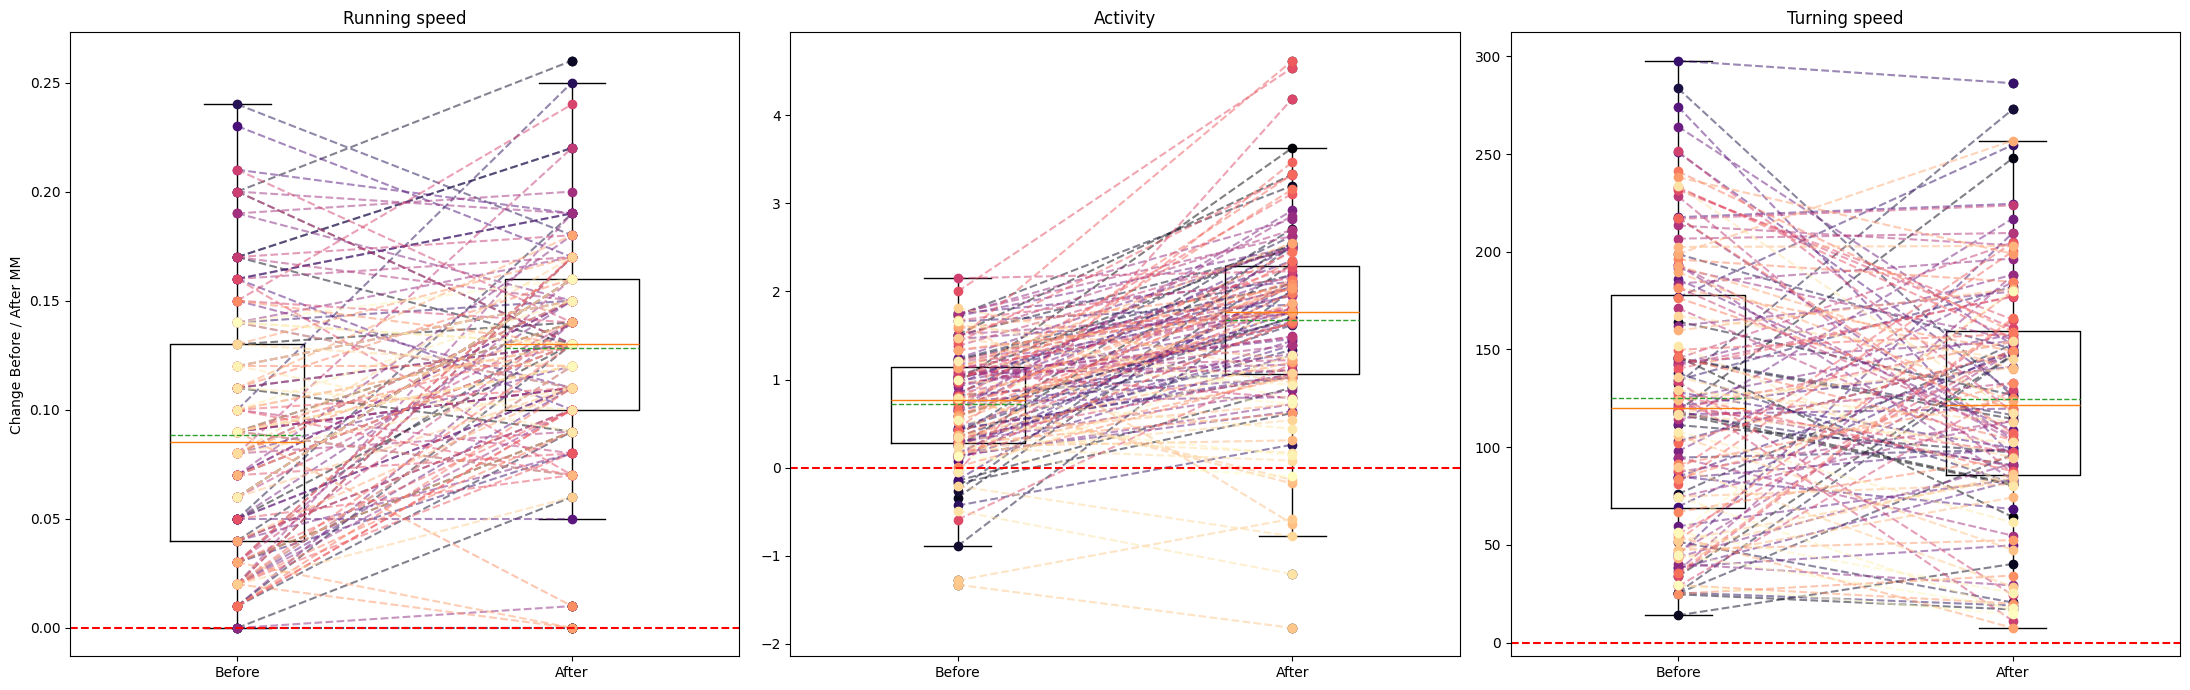

In [18]:
values_running_before, values_turning_before, values_activ_before, values_running_after, values_turning_after, values_activ_after = [], [], [], [], [], []

for key in data_aligned_dict.keys():
    for i in range(len(dict_ratios[key])):
        values_running_before.append(dict_means_before_after[key]['Velocity_0X_before'][i])
        values_running_after.append(dict_means_before_after[key]['Velocity_0X_after'][i])
        values_turning_before.append(dict_means_before_after[key]['Velocity_0Y_before'][i])
        values_turning_after.append(dict_means_before_after[key]['Velocity_0Y_after'][i])
        values_activ_before.append(dict_means_before_after[key]['z_560_before'][i])
        values_activ_after.append(dict_means_before_after[key]['z_560_after'][i])


N=len(values_running_before)
data = [values_running_before, values_running_after, values_turning_before, values_turning_after, values_activ_before, values_activ_after]
cmap = cm.magma
norm = mcolors.Normalize(vmin=0, vmax=N-1)

fig, axes = plt.subplots(1, 3, figsize=(22, 7), sharex=False)

datasets = [
    (values_running_before, values_running_after, 'Running speed', axes[0]),
    (values_activ_before, values_activ_after, 'Activity', axes[1]),
    (values_turning_before, values_turning_after, 'Turning speed', axes[2]),
]

for (before, after, title, ax) in datasets:
    ax.boxplot([before, after], positions=[1, 2], showmeans=True, meanline=True, widths=0.4)

    for i in range(N):
        color = cmap(norm(i))
        ax.plot(1, before[i], 'o', color=color)
        ax.plot(2, after[i], 'o', color=color)
        ax.plot([1, 2], [before[i], after[i]],
                linestyle='--', color=color, alpha=0.5)

    ax.axhline(0, color='r', linestyle='--')
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Before', 'After'])
    ax.set_title(title)

axes[0].set_ylabel('Change Before / After MM')
plt.tight_layout()
plt.show()


## Checking if data follow normal distribution

8.268223248247194 0.01601688782809432
The distribution is not normal (reject H0)


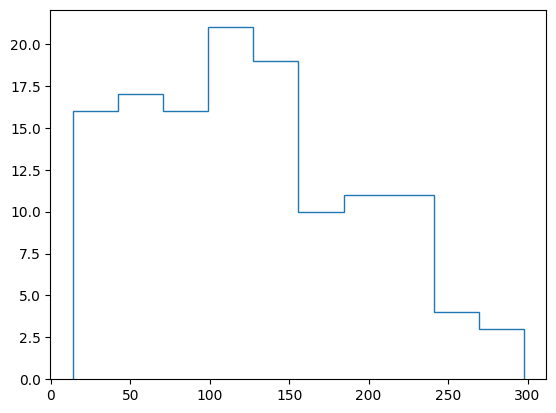

In [22]:
res = stats.normaltest(values_turning_before)

print(res.statistic, res.pvalue)

# print if the distribution is normal or not with alpha = 0.05
alpha = 0.05
if res.pvalue < alpha:
    print("The distribution is not normal (reject H0)")
else:    print("The distribution is normal (fail to reject H0)")

counts, bins = np.histogram(values_turning_before)
plt.stairs(counts, bins)

[-36.480000000000004, -81.98, 113.49, -37.33, 129.37, -30.860000000000014, -7.740000000000002, 26.28, -37.599999999999994, -14.030000000000001, 76.66, 71.09, 121.48, 140.39000000000001, -29.099999999999994, -157.44, -31.080000000000002, -48.55000000000001, -56.31, -26.459999999999994, 3.9399999999999977, -6.619999999999997, 47.77000000000001, 78.0, -11.509999999999991, 45.109999999999985, 62.93999999999998, 80.34999999999998, 164.7, -28.679999999999993, -16.569999999999993, 20.079999999999984, -122.65, 6.850000000000023, -179.0, 15.36, 44.88000000000001, 2.9000000000000057, 24.009999999999998, -77.27999999999999, 11.04, -111.80000000000001, 104.94000000000001, -113.30000000000001, 45.89999999999998, 33.12000000000002, 86.57, -110.13000000000001, 47.809999999999995, 17.52000000000001, 10.439999999999998, -11.010000000000002, 12.840000000000003, -36.21000000000001, 151.46, 102.94999999999999, 39.2, 26.070000000000007, -39.940000000000005, -31.629999999999995, -89.92999999999999, -10.1500

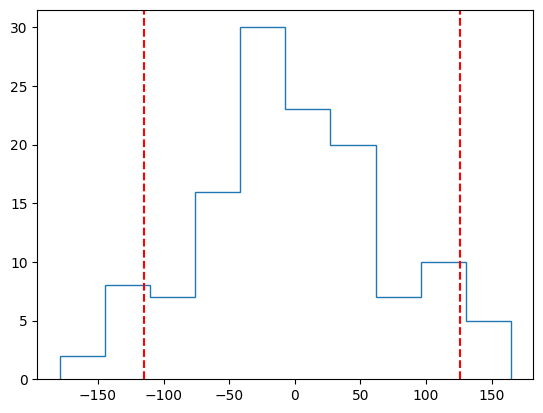

In [20]:
diff_turning, diff_running, diff_activ = [], [], []
for i in range(len(values_turning_after)):
    diff_t = values_turning_after[i] - values_turning_before[i]
    diff_r = values_running_after[i] - values_running_before[i]
    diff_a = values_activ_after[i] - values_activ_before[i]
    diff_turning.append(diff_t)
    diff_running.append(diff_r)
    diff_activ.append(diff_a)

print(diff_turning)

counts, bins = np.histogram(diff_turning)
res5 = np.percentile(diff_turning,5)
res95 = np.percentile(diff_turning,95)
plt.stairs(counts, bins)
plt.axvline(res5, color='r', linestyle='--')
plt.axvline(res95, color='r', linestyle='--')

## Checking if the change in speed/activity after MM is significant

## Plotting the % change of speed for running and turning

[-0.31, -0.56, 3.36, -0.32, 1.09, -0.21, -0.31, 1.88, -0.23, -0.13, 1.01, 2.82, 4.76, 1.06, -0.2, -0.56, -0.6, -0.24, -0.41, -0.23, 0.04, -0.26, 0.36, 0.44, -0.04, 0.44, 0.74, 1.16, 3.67, -0.22, -0.2, 0.17, -0.49, 0.03, -0.65, 0.18, 1.18, 0.02, 0.4, -0.42, 0.29, -0.42, 0.94, -0.52, 0.32, 0.27, 0.88, -0.57, 1.09, 0.11, 0.07, -0.27, 0.07, -0.19, 4.15, 2.24, 0.53, 0.3, -0.42, -0.26, -0.46, -0.05, 0.16, 0.01, -0.44, -0.62, 0.25, 0.03, 0.41, -0.42, -0.91, -0.82, -0.53, 3.51, -0.31, 3.81, 1.7, -0.29, 0.29, -0.19, -0.33, 0.27, -0.31, 1.32, 0.05, 1.46, -0.51, 2.45, 0.46, 3.69, -0.29, -0.34, -0.32, 0.37, -0.06, 0.42, 0.59, 0.37, -0.18, -0.32, -0.16, 0.1, -0.86, -0.27, -0.35, 0.29, 0.13, 0.0, 0.72, 0.09, 0.13, -0.55, 0.82, -0.68, 0.62, -0.3, -0.12, -0.13, 0.32, -0.12, -0.5, -0.47, -0.43, -0.78, -0.55, -0.6, 2.21, -0.51]


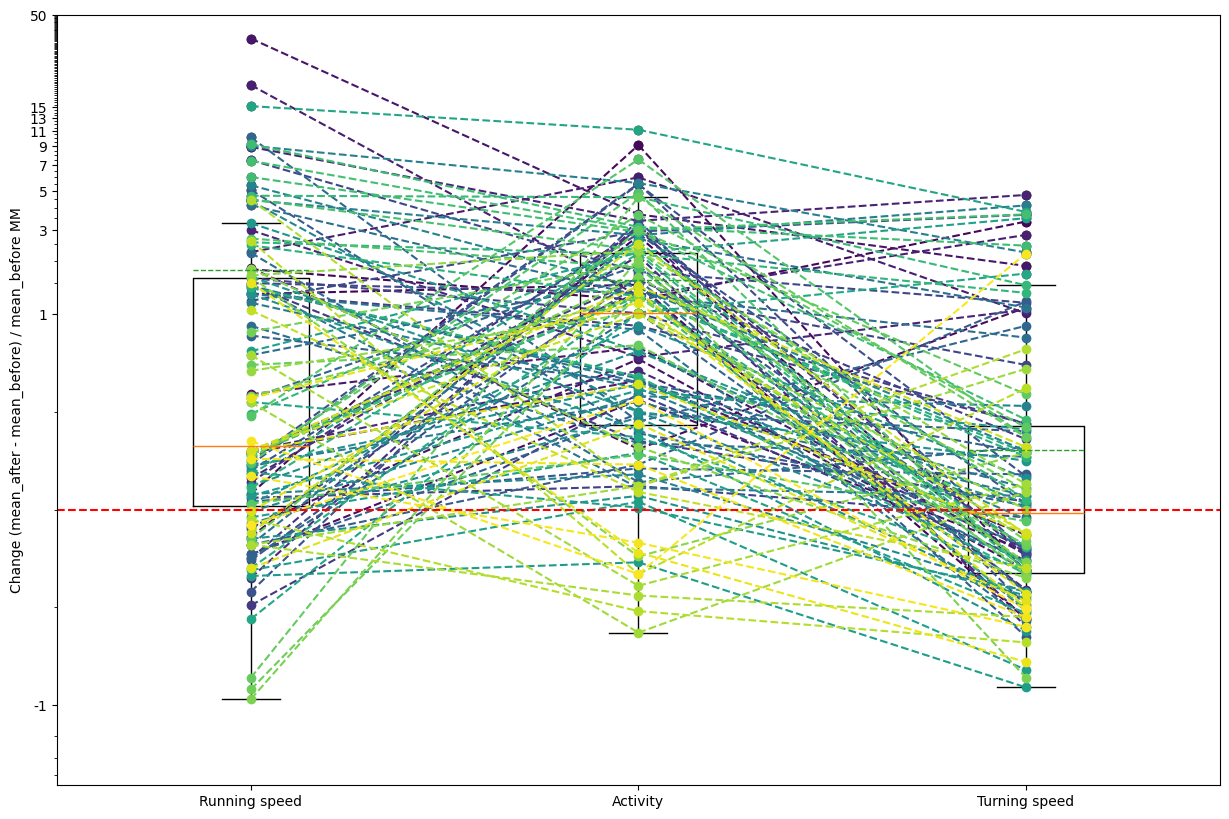

1.2559148632409156e-12 0.3694285329332154


In [25]:
values_running, values_turning, values_activ = [], [], []

for key in data_aligned_dict.keys():
    for i in range(len(dict_ratios[key])):
        values_running.append(dict_ratios[key]['Velocity_0X'][i])
        values_turning.append(dict_ratios[key]['Velocity_0Y'][i])
        values_activ.append(dict_ratios[key]['z_560'][i])

print(values_turning)
N=len(values_running)
data = [values_running, values_activ, values_turning]
cmap = cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=N-1)


fig, ax = plt.subplots(figsize=(15, 10))
ax.boxplot(data, positions=[1, 2, 3], showmeans=True, meanline=True, widths=0.3)
for i in range(N):
    color = cmap(norm(i)) 
    ax.plot(1, values_running[i], marker='o', color=color, linestyle='None')
    ax.plot(2, values_activ[i], marker='o', color=color, linestyle='None')
    ax.plot(3, values_turning[i], marker='o', color=color, linestyle='None')
    ax.plot([1,2], [values_running[i],values_activ[i]], marker='None', color=color, linestyle='--')
    ax.plot([2,3], [values_activ[i],values_turning[i]], marker='None', color=color, linestyle='--')
    
linear_ticks = np.arange(-1, 15, 2)
log_ticks = [15, 50]

ax.axhline(y=0, color='r', linestyle='--')
ax.set_yscale('symlog', linthresh=1)
ax.set_yticks(np.concatenate([linear_ticks, log_ticks]))
ax.set_yticklabels([str(t) for t in linear_ticks] + ['15', '50'])
ax.set_xticklabels(['Running speed', 'Activity', 'Turning speed'])
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
plt.ylabel('Change (mean_after - mean_before) / mean_before MM')
plt.show()


p_run = wilcoxon(values_running).pvalue
p_turn = wilcoxon(values_turning).pvalue
print(p_run, p_turn)

In [26]:
print(np.min(values_running))

-0.97


## Getting mean/median of values for each bin across all MM

In [24]:
spe_halt_bin_data_less_bs = data_aligned_csv.drop(['Position_0Y', 'Position_0X', 'saccade_probability_eye1', 'Acceleration_0Y', 'Acceleration_0X', 'Motor_Acceleration', 'Motor_Velocity', 'Time (s)', 'Halt Time', 'Encoder', 'Encoder_Unwrapped', 'dfF_470', 'dfF_560', 'dfF_410', 'z_470', 'z_410', 'Photodiode_int', 'CumulativeCounts_0X', 'CumulativeCounts_0Y','saccade_event_eye1','saccade_event_eye2'], axis=1) # 'saccade_event_eye1', 'saccade_event_eye2'

spe_halt_bin_data_less_bs = np.abs(spe_halt_bin_data_less_bs)

mm_bin_mean= spe_halt_bin_data_less_bs.groupby(['halt_index', 'bin_index']).mean()

bin_mean_across_mm = mm_bin_mean.groupby('bin_index').mean()

mm_bin_mean = mm_bin_mean.reset_index()

In [25]:
print(mm_bin_mean)

     halt_index  bin_index     z_560  Velocity_0X  Velocity_0Y  \
0             0          0  0.568764     0.008050    19.593339   
1             0          1  1.397602     0.049620    71.581932   
2             0          2  0.959964     0.110198   116.947052   
3             0          3  3.627589     0.094535    80.472235   
4             0          4  1.430417     0.026485    38.160500   
..          ...        ...       ...          ...          ...   
283          35          3  2.112866     0.054455    99.413008   
284          35          4  1.200680     0.169749    84.848116   
285          35          5  0.502092     0.167622    36.061607   
286          35          6  0.732104     0.102673    27.411216   
287          35          7  0.301973     0.113729    30.774546   

     Ellipse.Center.X_eye1  Ellipse.Center.Y_eye1  Pupil.Diameter_eye1  
0                 5.366102               1.614746            16.238589  
1                 7.406305               1.334063            

In [26]:
# Setting of the MM wanted for visualisation and annalysis
MM_id = 20
Bin_id = 3
spe_halt_data = data_aligned_csv.loc[data_aligned_csv['halt_index'] == MM_id]
spe_halt_bin_data = spe_halt_data.loc[spe_halt_data['bin_index'] == Bin_id]
print(spe_halt_bin_data)

         Encoder  Position_0X  Position_0Y  CumulativeCounts_0X  \
326021  142.2909      48.8000  -18399.7863            6148191.0   
326022  142.2941      48.8001  -18399.8431            6148191.0   
326023  142.2972      48.8003  -18399.9012            6148191.0   
326024  142.3002      48.8005  -18399.9599            6148396.0   
326025  142.3033      48.8007  -18400.0180            6148396.0   
...          ...          ...          ...                  ...   
328016  158.6103      49.2895  -18589.0252            6210112.0   
328017  158.6097      49.2897  -18588.9726            6210112.0   
328018  158.6092      49.2900  -18588.9212            6210112.0   
328019  158.6089      49.2902  -18588.8704            6210112.0   
328020  158.6086      49.2905  -18588.8193            6210112.0   

        CumulativeCounts_0Y  dfF_470  dfF_560  dfF_410   z_470   z_560  ...  \
326021           -4045912.0   0.0054   1.0073   1.0061  0.5653  0.5768  ...   
326022           -4045912.0   0.0055 

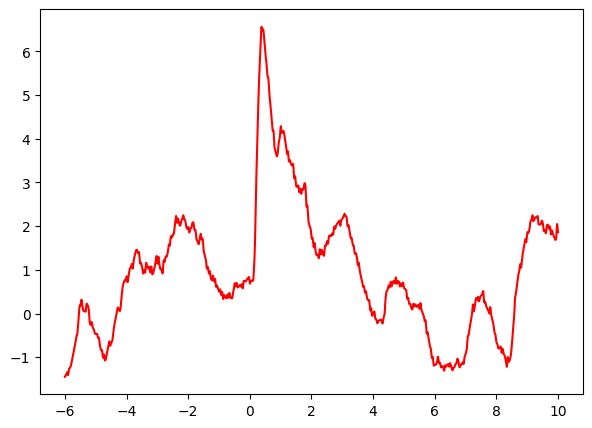

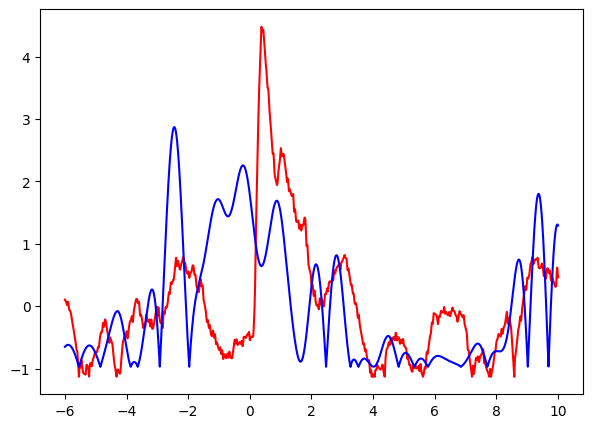

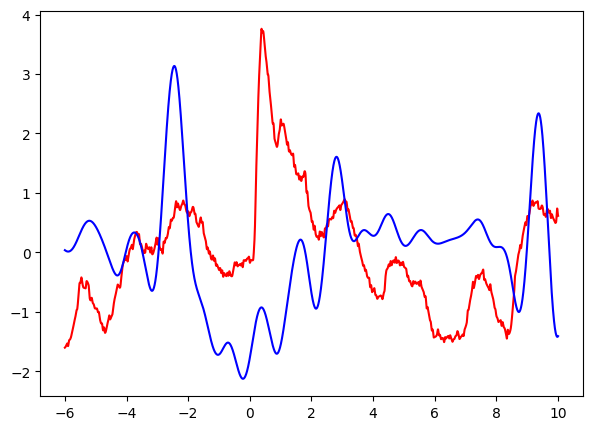

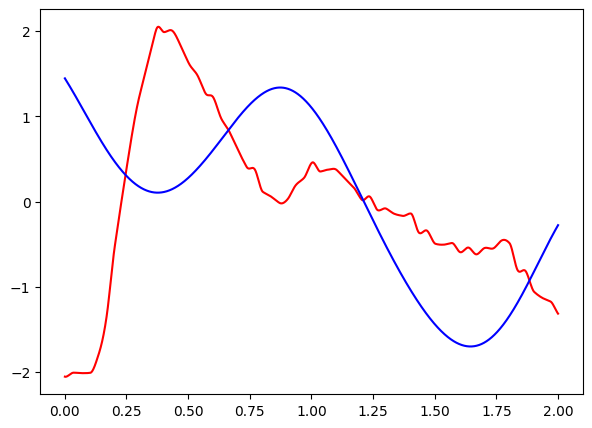

In [27]:
# Setting of the MM wanted for visualisation and annalysis
MM_id = 0
Bin_id = 3
spe_halt_data = data_aligned_csv.loc[data_aligned_csv['halt_index'] == MM_id]
spe_halt_bin_data = spe_halt_data.loc[spe_halt_data['bin_index'] == Bin_id]

# Visualisation of the z score 560 for selected MM
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(spe_halt_data['Time (s)'], spe_halt_data['z_560'], color = 'red')
# ax.plot(spe_halt_data['Time (s)'], np.abs(spe_halt_data['Velocity_0Y'])/100, color = 'blue')
# plt.plot(spe_halt_data['Time (s)'], np.abs(spe_halt_data['z_560']), color = 'red')
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(spe_halt_data['Time (s)'], zscore(np.abs(spe_halt_data['z_560'])), color = 'red')
ax.plot(spe_halt_data['Time (s)'], zscore(np.abs(spe_halt_data['Velocity_0Y'])), color = 'blue')
# plt.plot(spe_halt_data['Time (s)'], np.abs(spe_halt_data['z_560']), color = 'red')
plt.show()

# for i in range(np.max(data_aligned_csv['halt_index'])):
#     spe_halt_data = data_aligned_csv.loc[data_aligned_csv['halt_index'] == i]
#     plt.plot(spe_halt_data['Time (s)'], spe_halt_data['Velocity_0Y'], color = 'red')
#     plt.show()
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(spe_halt_data['Time (s)'], zscore(spe_halt_data['z_560']), color = 'red')
ax.plot(spe_halt_data['Time (s)'], zscore(spe_halt_data['Velocity_0Y']), color = 'blue')
plt.show()


fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(spe_halt_bin_data['Time (s)'], zscore(np.abs(spe_halt_bin_data['z_560'])), color = 'red')
ax.plot(spe_halt_bin_data['Time (s)'], zscore(np.abs(spe_halt_bin_data['Velocity_0Y'])), color = 'blue')
plt.show()

In [28]:
np.max(data_aligned_csv['halt_index'])

35

In [29]:
spe_halt_bin_before_data = spe_halt_data.loc[spe_halt_data['bin_index'] == 3]
spe_halt_bin_after_data = spe_halt_data.loc[spe_halt_data['bin_index'] == 3]
print(spe_halt_bin_before_data.loc[spe_halt_bin_before_data['Time (s)'] >= np.percentile(spe_halt_bin_before_data['Time (s)'], 12.5)])
mean_before = np.mean(np.abs(spe_halt_bin_before_data['Velocity_0X']))
mean_after = np.mean(np.abs(spe_halt_bin_after_data['Velocity_0X']))
print(mean_before,mean_after)

ratio_before_after = (mean_after-mean_before)/mean_before
print(ratio_before_after)

# if ratio_before_after > 1:
#     ratio_before_after -=1
#     ratio_before_after *=(-1)

# if ratio_before_after < 1:
#     ratio_before_after = 1 -ratio_before_after

print(f'Mean speed change : {np.round(ratio_before_after*100, 2)}% after MM.')


       Encoder  Position_0X  Position_0Y  CumulativeCounts_0X  \
6251  273.6481       5.7069   -6941.6191             719132.0   
6252  273.6566       5.7071   -6941.7078             719403.0   
6253  273.6650       5.7073   -6941.7957             719403.0   
6254  273.6733       5.7076   -6941.8817             719403.0   
6255  273.6816       5.7078   -6941.9654             719403.0   
...        ...          ...          ...                  ...   
7996  284.2022       5.8637   -7064.2840             738817.0   
7997  284.2040       5.8638   -7064.3662             738817.0   
7998  284.2059       5.8638   -7064.4501             738817.0   
7999  284.2078       5.8639   -7064.5369             738817.0   
8000  284.2099       5.8639   -7064.6271             738817.0   

      CumulativeCounts_0Y  dfF_470  dfF_560  dfF_410   z_470   z_560  ...  \
6251           -1526454.0  -0.0005   1.0684   0.9993 -0.2051  4.1856  ...   
6252           -1526643.0  -0.0005   1.0688   0.9995 -0.2116  4.2

## Correlation 1v1 and correlation matrix

Correlation between z_560 and Position_0X: -0.006591422373265723
z_560
Velocity_0X
Velocity_0Y
Ellipse.Center.X_eye1
Ellipse.Center.Y_eye1
Pupil.Diameter_eye1


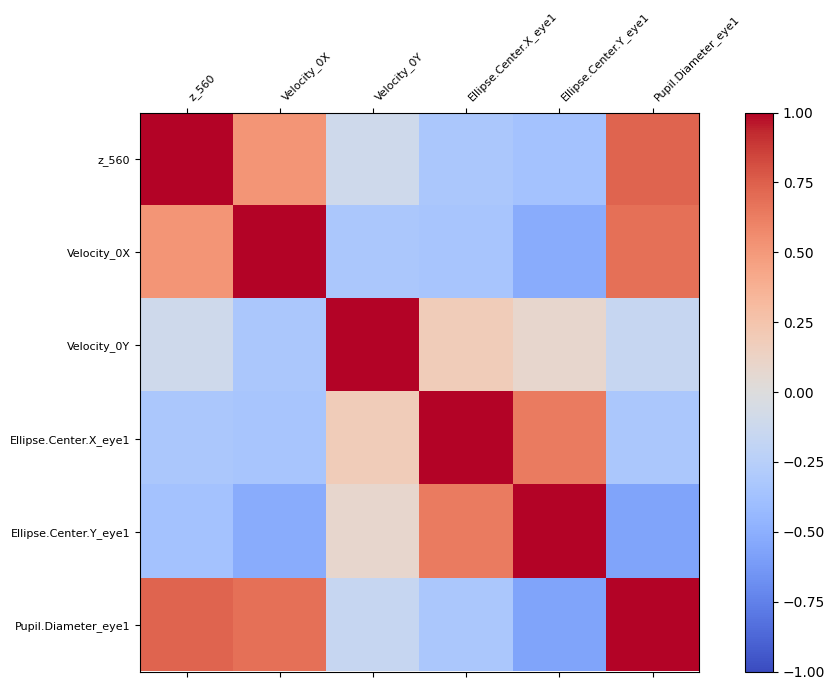

In [30]:
# red = gecko = 560 --> z_560 used for neural activity
# motor_velocity, velocity_0Y, Velocity_0X, saccade_probability_eye1, pupil (elipse ?) diameter

# The two features you want to see the correlation of
c1 = spe_halt_data['z_560']
c2 = spe_halt_data['Position_0X']
numpy_correlation = np.corrcoef(c1, c2)[0, 1]
print(f'Correlation between {c1.name} and {c2.name}:', numpy_correlation)

# Correlation matrix of all features minus what is specified line just below
spe_halt_data_no_bs = spe_halt_data.drop(['Position_0Y', 'Position_0X', 'bin_index', 'saccade_probability_eye1', 'Acceleration_0Y', 'Acceleration_0X', 'Motor_Acceleration', 'Motor_Velocity', 'Time (s)', 'Halt Time', 'Encoder', 'Encoder_Unwrapped', 'dfF_470', 'dfF_560', 'dfF_410', 'z_470', 'z_410', 'Photodiode_int', 'halt_index', 'CumulativeCounts_0X', 'CumulativeCounts_0Y','saccade_event_eye1','saccade_event_eye2'], axis=1) # 'saccade_event_eye1', 'saccade_event_eye2'
col_names = spe_halt_data_no_bs.columns
print("\n".join(col_names))
# position of pupils in absolute values
# table_global_ratio
spe_halt_data_no_bs['Ellipse.Center.X_eye1'] = abs(spe_halt_data_no_bs['Ellipse.Center.X_eye1'])
spe_halt_data_no_bs['Ellipse.Center.Y_eye1'] = abs(spe_halt_data_no_bs['Ellipse.Center.Y_eye1'])
spe_halt_data_no_bs['Pupil.Diameter_eye1'] = abs(spe_halt_data_no_bs['Pupil.Diameter_eye1'])
corr = spe_halt_data_no_bs.corr()
n = corr.shape[0]

fig, ax = plt.subplots(figsize=(10, 7))
cax = ax.matshow(corr, vmin=-1, vmax=1, cmap='coolwarm')

ax.set_xticks(np.arange(n), corr.columns, fontsize=8, rotation=45, ha='left')
ax.set_yticks(np.arange(n), corr.columns, fontsize=8)

plt.colorbar(cax, ax=ax)
plt.tight_layout()
plt.show()

In [31]:
single_bin_mean_across_mm = mm_bin_mean.loc[mm_bin_mean['bin_index'] == 0]
single_bin_mean_across_mm = single_bin_mean_across_mm.drop(['bin_index', 'halt_index'], axis=1)
print(spe_halt_data)

        Encoder  Position_0X  Position_0Y  CumulativeCounts_0X  \
0      257.7982       5.3904   -6741.2109             679112.0   
1      257.7991       5.3904   -6741.2292             679112.0   
2      257.8000       5.3904   -6741.2477             679114.0   
3      257.8011       5.3904   -6741.2660             679114.0   
4      257.8023       5.3904   -6741.2839             679114.0   
...         ...          ...          ...                  ...   
15996  282.6828       5.9101   -7059.8803             744559.0   
15997  282.6966       5.9101   -7060.0264             744559.0   
15998  282.7105       5.9101   -7060.1701             744559.0   
15999  282.7244       5.9101   -7060.3131             744559.0   
16000  282.7385       5.9101   -7060.4569             744559.0   

       CumulativeCounts_0Y  dfF_470  dfF_560  dfF_410   z_470   z_560  ...  \
0               -1482310.0   0.0024   0.9730   0.9957  0.1721 -1.4471  ...   
1               -1482310.0   0.0024   0.9730   0.99

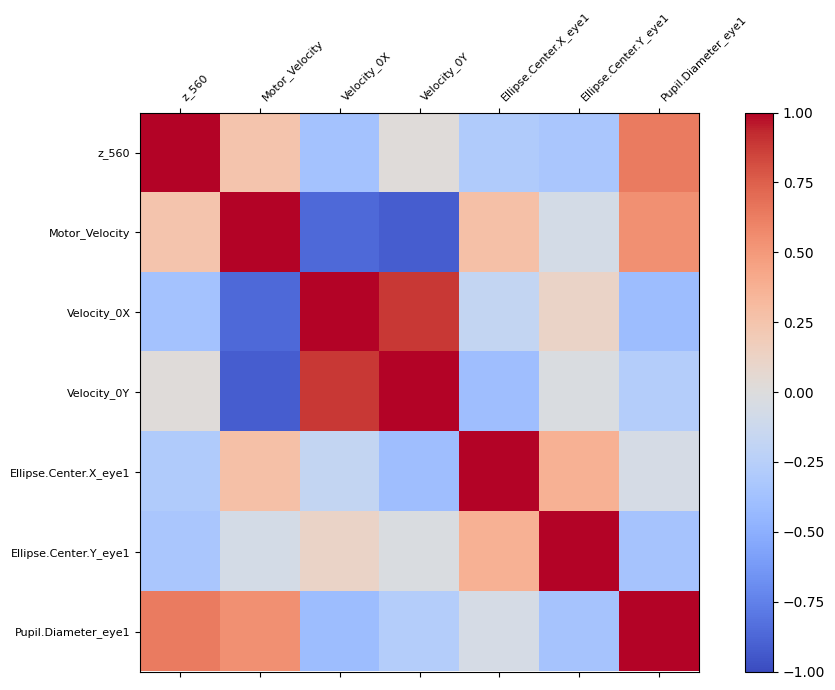

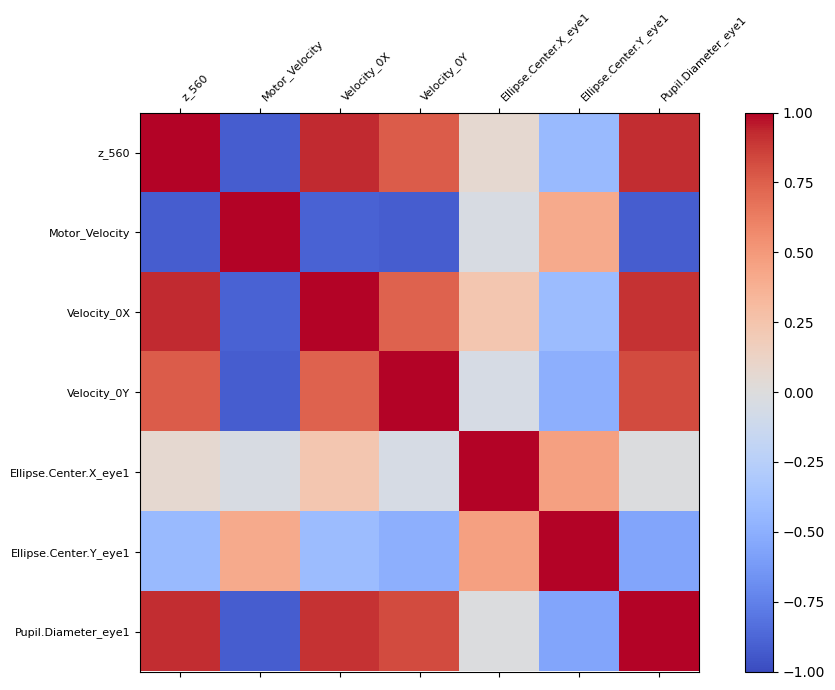

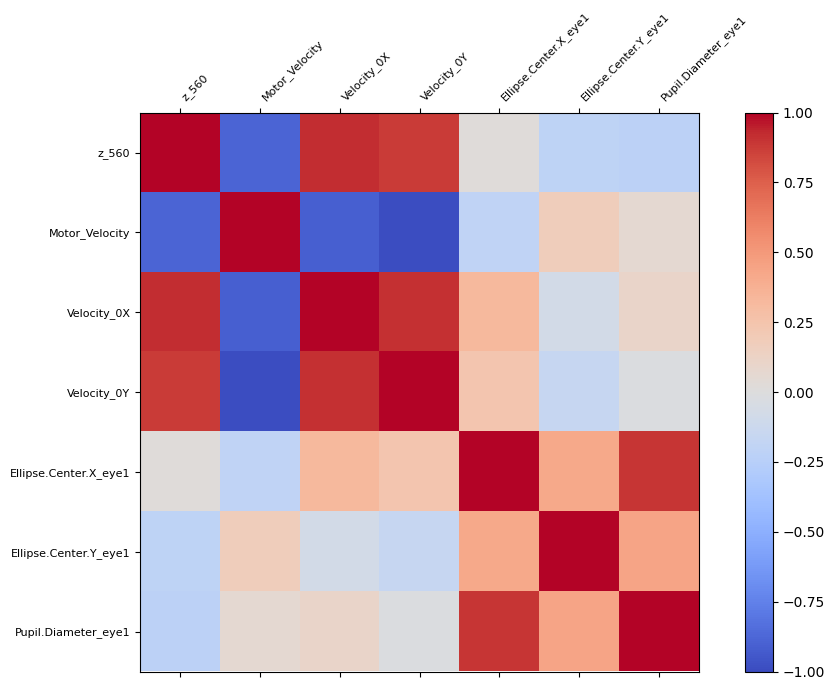

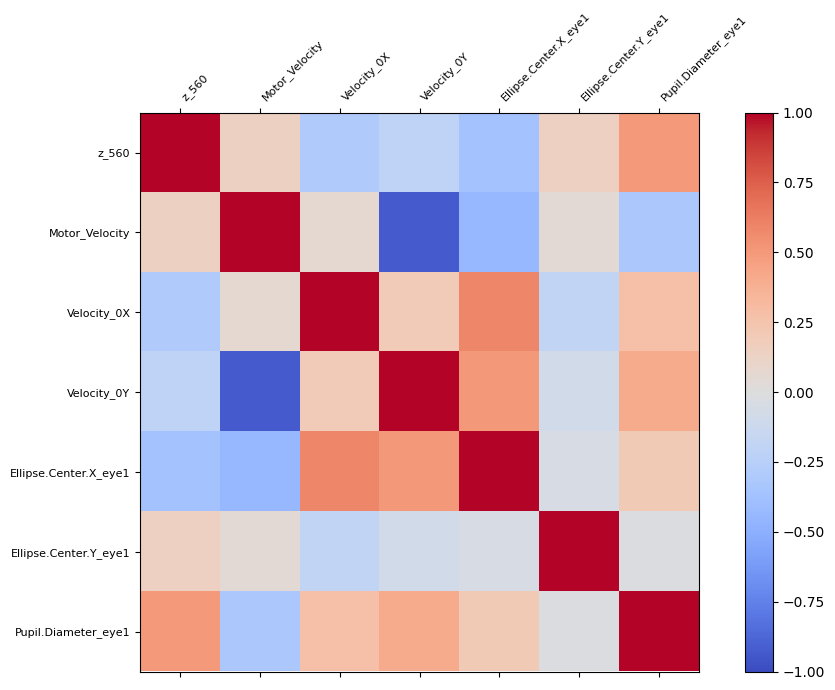

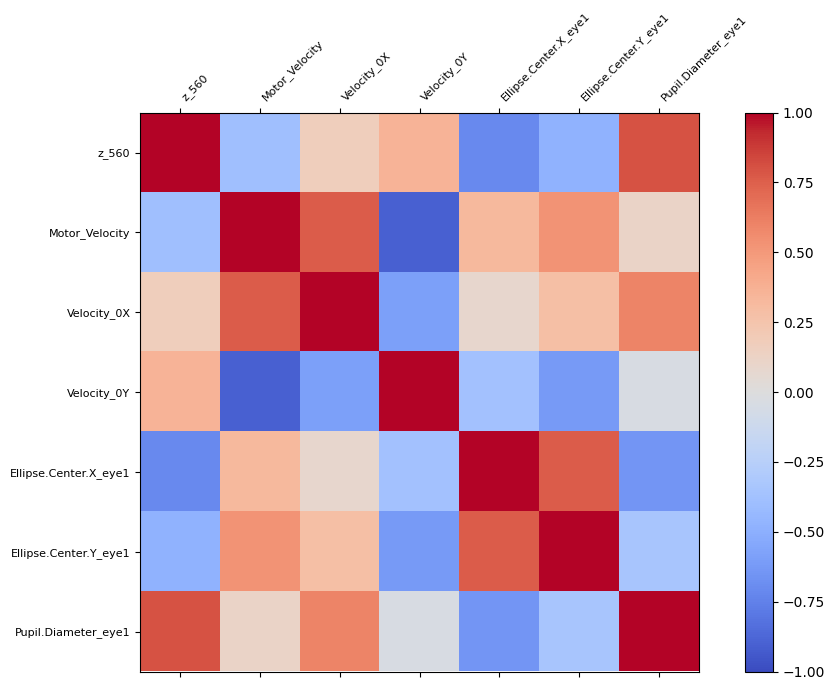

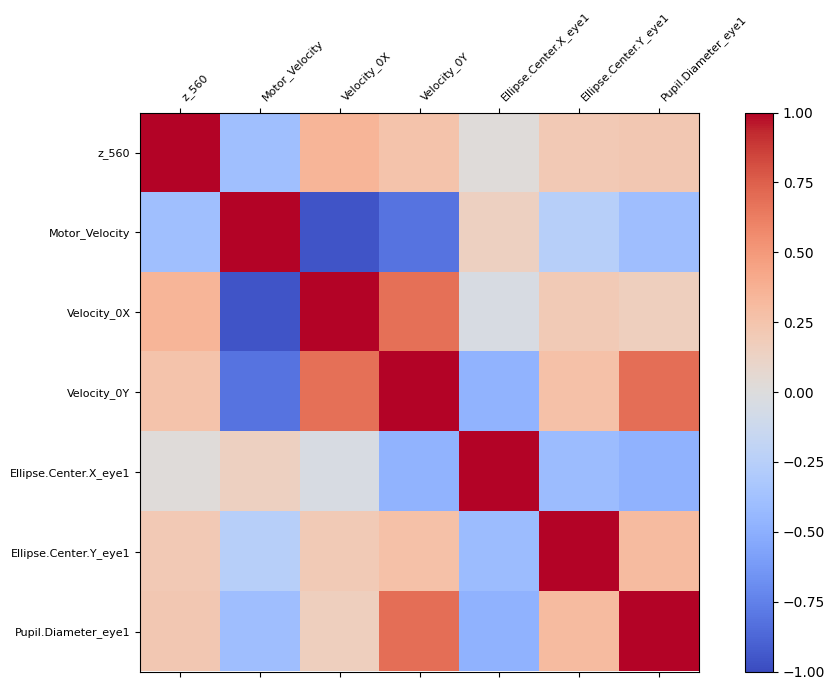

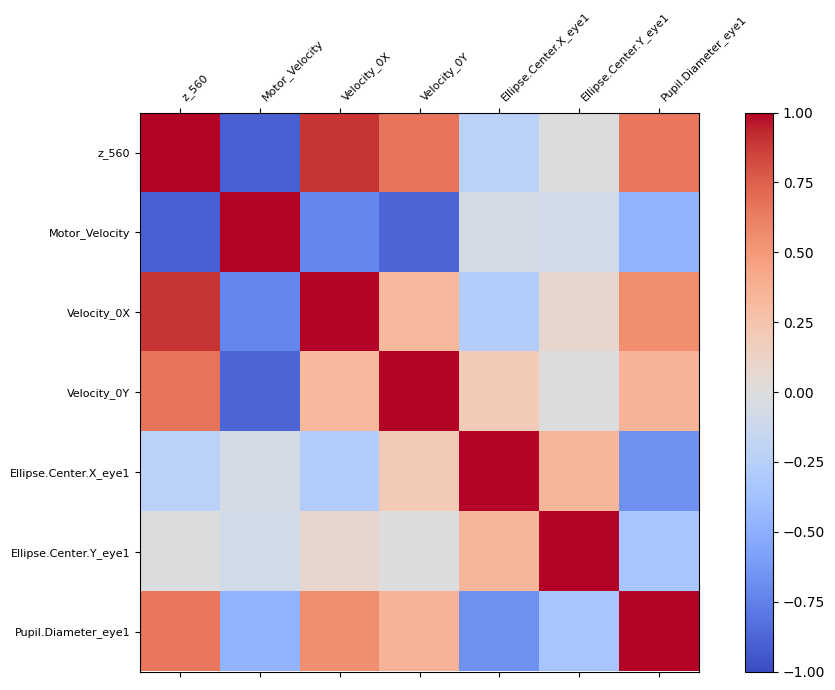

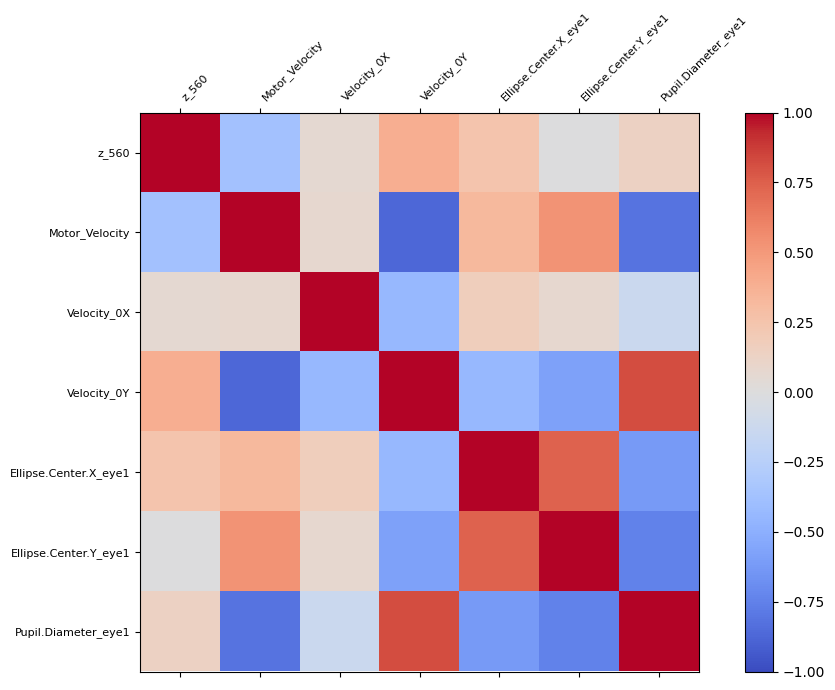

In [32]:
# Correlation matrix of all features minus what is specified line just below
# spe_halt_bin_before_data
# spe_halt_bin_after_data
for Bin_id in range(0, 8):
    # single_bin_mean_across_mm = mm_bin_mean.loc[mm_bin_mean['bin_index'] == Bin_id]
    # single_bin_mean_across_mm_no_bs = single_bin_mean_across_mm.drop(['bin_index', 'halt_index'], axis=1)
    # col_names = single_bin_mean_across_mm_no_bs.columns
    # print("\n".join(col_names))
    # print(single_bin_mean_across_mm_no_bs)
    spe_halt_bin_data = spe_halt_data.loc[spe_halt_data['bin_index'] == Bin_id]
    spe_halt_bin_data_no_bs = spe_halt_bin_data.drop(['Position_0Y', 'Position_0X', 'bin_index', 'saccade_probability_eye1', 'Acceleration_0Y', 'Acceleration_0X', 'Motor_Acceleration', 'Time (s)', 'Halt Time', 'Encoder', 'Encoder_Unwrapped', 'dfF_470', 'dfF_560', 'dfF_410', 'z_470', 'z_410', 'Photodiode_int', 'halt_index', 'CumulativeCounts_0X', 'CumulativeCounts_0Y','saccade_event_eye1','saccade_event_eye2'], axis=1) # 'saccade_event_eye1', 'saccade_event_eye2'
    col_names = spe_halt_bin_data_no_bs.columns
    # print("\n".join(col_names))
    # print(spe_halt_bin_data_no_bs)
    # position of pupils in absolute values
    spe_halt_bin_data_no_bs['Ellipse.Center.X_eye1'] = abs(spe_halt_bin_data_no_bs['Ellipse.Center.X_eye1'])
    spe_halt_bin_data_no_bs['Ellipse.Center.Y_eye1'] = abs(spe_halt_bin_data_no_bs['Ellipse.Center.Y_eye1'])
    corr = spe_halt_bin_data_no_bs.corr()
    n = corr.shape[0]

    fig, ax = plt.subplots(figsize=(10, 7))
    cax = ax.matshow(corr, vmin=-1, vmax=1, cmap='coolwarm')

    ax.set_xticks(np.arange(n), corr.columns, fontsize=8, rotation=45, ha='left')
    ax.set_yticks(np.arange(n), corr.columns, fontsize=8)
    # ax.set_title(f'Matrix correlation bin #{Bin_id}')

    plt.colorbar(cax, ax=ax)
    plt.tight_layout()
    plt.show()

In [33]:
x = np.column_stack([spe_halt_data['Motor_Velocity'], spe_halt_data['Velocity_0X'], spe_halt_data['Velocity_0Y'], spe_halt_data['Pupil.Diameter_eye1'], spe_halt_data['Ellipse.Center.X_eye1'], spe_halt_data['Ellipse.Center.Y_eye1']]) # , spe_halt_data['saccade_probability_eye1'], spe_halt_data['saccade_event_eye1']
y = spe_halt_data['z_560']

model = LinearRegression().fit(x, y)

print('multiple linear regression coef:', model.coef_) 
print('multiple linear regression R²:', model.score(x, y))

multiple linear regression coef: [0.01132821 0.77277359 0.00144972 0.43539515 0.04000641 0.33682709]
multiple linear regression R²: 0.5646192288606426


In [34]:
# a = spe_halt_data.drop(['z_560', 'Halt Time'], axis=1) # 'saccade_event_eye1', 'saccade_event_eye2'
# b = spe_halt_data['z_560']

# scaler = StandardScaler()
# a_scaled = scaler.fit_transform(a)
# print(a_scaled)

# def compute_auc(ax2, ax1=spe_halt_data['Time (s)']):
#     if ax2 is None:
#         print('No variable mentionned. Please determine ax2')
#         return None
#     AUC = auc(ax1, ax2)
#     return AUC

# AUC = compute_auc(ax2=spe_halt_data['z_560'])
# print(AUC)

## PCA : Whithout considering z_560, create new uncorrelated variables that explain the variance the most
## Detail features present in new principal components

In [35]:
# Keep only numeric columns
a = spe_halt_data.drop(['Position_0Y', 'Position_0X', 'bin_index', 'saccade_probability_eye1', 'Acceleration_0Y', 'Acceleration_0X', 'Motor_Acceleration', 'Motor_Velocity', 'Time (s)', 'Halt Time', 'Encoder', 'Encoder_Unwrapped', 'dfF_470', 'dfF_560', 'dfF_410', 'z_470', 'z_410', 'Photodiode_int', 'halt_index', 'CumulativeCounts_0X', 'CumulativeCounts_0Y','saccade_event_eye1','saccade_event_eye2'], axis=1) # 'saccade_event_eye1', 'saccade_event_eye2'
spe_halt_data_num = a.select_dtypes(include=[np.number])

# Target variable
target = "z_560"

# Drop rows with NaNs
spe_halt_data_num = spe_halt_data_num.dropna()

# Separate z_560
y = spe_halt_data_num[target].values
X = spe_halt_data_num.drop(columns=[target])

# Z-score variables
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

# PCA
pca = PCA()
X_pca = pca.fit_transform(Xz)


explained_var = pca.explained_variance_ratio_

feature_names = X.columns

for pc_idx, (var, component) in enumerate(zip(explained_var, pca.components_)):

    loadings = pd.Series(component, index=feature_names)

    # Sort by absolute loading
    loadings_sorted = loadings.reindex(
        loadings.abs().sort_values(ascending=False).index
    )

    print(f"\nPC{pc_idx+1}: {var*100:.2f}% variance explained")
    for feature, value in loadings_sorted.items():
        print(f"{feature:25s} {value:+.3f}")



PC1: 61.18% variance explained
Ellipse.Center.Y_eye1     +0.509
Pupil.Diameter_eye1       +0.502
Ellipse.Center.X_eye1     -0.495
Velocity_0X               +0.477
Velocity_0Y               -0.126

PC2: 21.51% variance explained
Velocity_0Y               +0.912
Ellipse.Center.X_eye1     -0.273
Velocity_0X               -0.243
Ellipse.Center.Y_eye1     +0.185
Pupil.Diameter_eye1       +0.004

PC3: 7.61% variance explained
Velocity_0X               +0.612
Ellipse.Center.X_eye1     +0.423
Ellipse.Center.Y_eye1     -0.422
Velocity_0Y               +0.374
Pupil.Diameter_eye1       +0.359

PC4: 5.85% variance explained
Pupil.Diameter_eye1       +0.780
Velocity_0X               -0.580
Ellipse.Center.X_eye1     +0.214
Velocity_0Y               -0.086
Ellipse.Center.Y_eye1     -0.039

PC5: 3.84% variance explained
Ellipse.Center.Y_eye1     +0.726
Ellipse.Center.X_eye1     +0.675
Pupil.Diameter_eye1       -0.103
Velocity_0Y               +0.068
Velocity_0X               +0.052


## Correlation of each PC with target z_560

In [36]:
pc_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])

pc_y_corr = pc_df.apply(lambda pc: np.corrcoef(pc, y)[0,1]) # pearson correlation between each pc and y (target)

print(f'\n{pc_y_corr.sort_values(key=np.abs, ascending=False)}')



PC1    0.665557
PC4    0.290998
PC3    0.143234
PC5    0.126587
PC2    0.015994
dtype: float64


## PLS Regression : Which features explain variance in X that is also predictive of y

In [37]:
pls = PLSRegression(n_components=5)
pls.fit(Xz, y)

pls_loadings = pd.Series(pls.x_weights_[:,0], index=X.columns)
pls_loadings.sort_values(key=np.abs, ascending=False)

Pupil.Diameter_eye1      0.621651
Ellipse.Center.Y_eye1    0.502756
Velocity_0X              0.437761
Ellipse.Center.X_eye1   -0.400827
Velocity_0Y             -0.092139
dtype: float64

## Ridge Regression

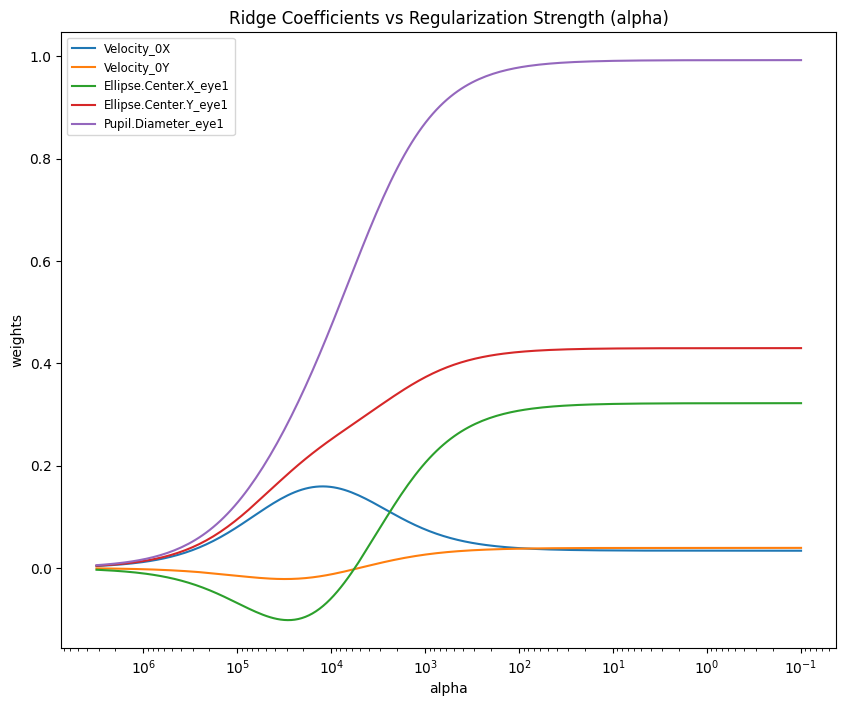

In [38]:
n_alphas = 200
alphas = np.logspace(-1, 6.5, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(Xz, y)
    coefs.append(ridge.coef_)

plt.figure(figsize=(10, 8))
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge Coefficients vs Regularization Strength (alpha)")
plt.axis("tight")
plt.legend(
    [feature_names[i] for i in range(X.shape[1])], loc="upper left", fontsize="small"
)
plt.show()

Best alpha: 41264.62373784472


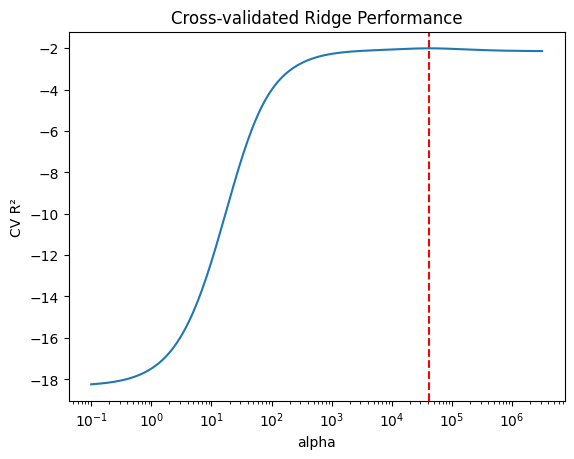

In [39]:
tscv = TimeSeriesSplit(n_splits=5)

mean_scores = []

for a in alphas:
    scores = []
    for train_idx, test_idx in tscv.split(Xz):
        model = Ridge(alpha=a, fit_intercept=False)
        model.fit(Xz[train_idx], y[train_idx])
        y_pred = model.predict(Xz[test_idx])
        scores.append(r2_score(y[test_idx], y_pred))
    mean_scores.append(np.mean(scores))

mean_scores = np.array(mean_scores)

best_alpha = alphas[np.argmax(mean_scores)]
print("Best alpha:", best_alpha)

plt.figure()
plt.semilogx(alphas, mean_scores)
plt.axvline(best_alpha, color='r', linestyle='--')
plt.xlabel("alpha")
plt.ylabel("CV R²")
plt.title("Cross-validated Ridge Performance")
plt.show()

/tmp/ipykernel_2170319/4192464950.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coefs_at_best_alpha = coefs[int(np.where(alphas == best_alpha)[0])]


Pupil.Diameter_eye1      0.231737
Ellipse.Center.Y_eye1    0.158162
Velocity_0X              0.126687
Ellipse.Center.X_eye1   -0.098098
Velocity_0Y             -0.021119
dtype: float64


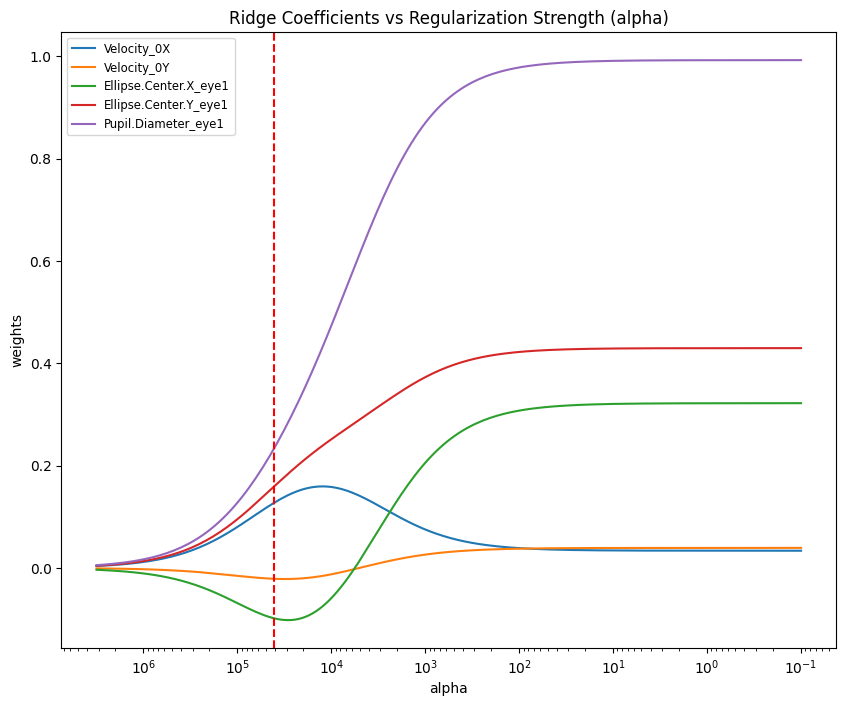

In [40]:
coefs_at_best_alpha = coefs[int(np.where(alphas == best_alpha)[0])]
coef_best_alpha_organized = pd.Series(coefs_at_best_alpha, index=X.columns)
print(coef_best_alpha_organized.sort_values(key=np.abs, ascending=False))

plt.figure(figsize=(10, 8))
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axvline(best_alpha, color='r', linestyle='--')
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge Coefficients vs Regularization Strength (alpha)")
plt.axis("tight")
plt.legend(
    [feature_names[i] for i in range(X.shape[1])], loc="upper left", fontsize="small"
)
plt.show()